# **PART 1 : &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Dunnhumby, The Complete Journey Analysis**

## **INTRODUCTION:**
The Dunnhumby Dataset consists of anonymized shopping data from 2,500 households and spanning over two years. The data is well formatted and requires very little processing. It contains generic information about the household and its composition, as well as consumption information in groceries, broad description of the products, and details about the potential discounts coupons that were redeemed. <br>
In this analysis, we focus mainly on food products since we want to establish a link with openfoodfacts dataset. We hence use only three files of Dunnhumby : hh_demographic.csv, product.csv, transaction_data.csv. <br>
We start studying each feature's statistics in order to identify the most relevant and important ones. Then we merge the three files in order to have one dataframe containing all the significant features. Then we analyse the correlations between attributes of the dataset in order to find potential links. <br>

**For easier readability:** <br>
- The notebook is divided into parts each one focusing on a part of the analysis
- Comments explain what has been done in the **next** cells up until the following comment. They are in italic.

In [1]:
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd
import seaborn as sns

In [2]:
def plotDistributionDataset(df):
    n_row, n_col = df.shape
    columns = list(df.columns)
    plt.figure(num = None, figsize = (5*3,5*np.ceil(n_col/3)))
    for i in range(n_col):
        plt.subplot(int(np.ceil(n_col/3)),3,i+1)
        subdf = df.iloc[:,i]
        if (not np.issubdtype(type(subdf.iloc[0]), np.number)):
            valueCounts = subdf.value_counts()
            valueCounts.sort_index(ascending=True).plot.bar()
        else:
            if(subdf.dtype == 'int64'):
                subdf.hist(bins = subdf.max()-subdf.min())
            else :
                subdf.hist()
                
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columns[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [3]:
def correct_indecome(x):
    if(x == "Under 15K"):
        c = "-15K"
    elif(len(x) == 6):
        c = '-'.join([x.split('-')[0].zfill(3),x.split('-')[1].zfill(4)])
    else:
        c = x
    return c

In [4]:
def correct_marital_status(x):
    if(x == "A"):
        c = "Married"
    elif(x == "B"):
        c = "Single"
    elif(x == "U"):
        c = "Unknown"
    return c

In [5]:
def replace_unknowns(hh_comp, marital_status, hh_size):
    if(hh_comp == '2 Adults Kids' and marital_status == 'Unknown'):
        marital_status = 'Married'
    elif(hh_comp == '1 Adult Kids' and marital_status == 'Unknown'):
        marital_status = 'Single' 
    elif((hh_comp == 'Single Male' or hh_comp == 'Single Female') and marital_status == 'Unknown'):
        marital_status = 'Single' 
    elif(hh_size == '1' and marital_status == 'Unknown'):
        marital_status = 'Single' 
    else:
        marital_status = marital_status
    return marital_status

In [36]:
from time import time

In [40]:
def ploting_stacked_plot(count,elements,list_specifics,specific,text):
    #print(count)
    #print(elements)
    #print(list_specifics)
    count = np.array(count)
    c = pd.DataFrame(np.transpose(count),columns = tuple(list_specifics),index =tuple(set(elements)))
    c1 = c.copy()
    c1.insert(0, 'product', c.index)
    c1.to_csv(str(round(time())) + '.csv', index=False)
    print(c)
    sns.set()
    if len(elements) <= 12:
        sns.set_palette("Paired", 12)
    else:
        sns.set_palette("hls", 20)
    c.T.plot(kind = 'bar',stacked = True,figsize = (15,10))
    plt.ylabel('Purchases Counts per Food')
    plt.xlabel(specific)
    plt.title(['Amount of purchases of '+text+' foods along '+specific])
    plt.show()

In [34]:
def ploting_specific_general(dataset, specific):
    
    list_specifics = dataset.loc[:,specific].value_counts().sort_index(ascending=True).index
    list_food = []
    for i in range(len(list_specifics)):
        test = dataset[dataset.loc[:,specific].apply(lambda x: x == list_specifics[i])]
        list_food.append(list(test.SUB_COMMODITY_DESC.value_counts()[:10].index))
        
    count = 0
    elements3 = []
    elements2 = []
    for l in list_food:
        elements1 = []
        for element in l:
            inter = list_food.copy()
            inter.remove(l)
            list_final = [x for xs in inter for x in xs]
            if(element not in list_final or list_final.count(element) <int(0.50*len(list_specifics))):
                elements1.append(element)
                elements3.append(element)
            else:
                elements2.append(element)
        count += 1
        
    count1 = []
    count2 = []
    for list_specific in dataset.loc[:,specific].unique():
        for food in set(elements2):
            count2.append(int(dataset[(dataset.loc[:,specific] == list_specific) & (dataset.SUB_COMMODITY_DESC == food)].shape[0] / \
                              dataset[(dataset.loc[:,specific] == list_specific)].shape[0] * 100))

        count1.append(count2)
        count2 = []
    
    ploting_stacked_plot(count1,elements2,list_specifics,specific,'most commun') 
    
    count1 = []
    count2 = []
    for list_specific in dataset.loc[:,specific].unique():
        for food in set(elements3):
            count2.append(int(dataset[(dataset.loc[:,specific] == list_specific) & (dataset.SUB_COMMODITY_DESC == food)].shape[0] / \
                              dataset[(dataset.loc[:,specific] == list_specific)].shape[0]*100))

        count1.append(count2)
        count2 = []
        
    elements3 = list(set(elements3))
    count1_array = np.array(count1)
    elements = []
    count1 = np.array([])
    index_col = []
    for i in range(len(count1_array[0])):
        if(np.count_nonzero(count1_array[:,i]) != 0 and np.count_nonzero(count1_array[:,i]) <= 2):
            elements.append(elements3[i])
        else:
            index_col.append(i)
            
    count1 = np.delete(count1_array,index_col, 1)
    ploting_stacked_plot(count1,elements,list_specifics,specific,'specific')

## **A. Feature Analysis:**

In this part, we load the three subdatasets we decided to use and conduct some preliminary study on each one of them.

#### **A1. Demographic Analysis:**

_**Comments:** <br>
The hh_demographic subdataset contains demographic information on 801 households. For each one, it offers the age range, the marital status, the income range, type of ownership, household composition, size, and number of kids. This dataset is not complete since the Dunnhumby study was done on 2500 households, while there is demographic information on 801 only._

In [8]:
demographic = pd.read_csv('/media/florian/Data/Datasets/ADA/dunnhumby/hh_demographic.csv', delimiter=',')
print(f'The number of rows and columns in the dataframe is respectively {demographic.shape[0]} and {demographic.shape[1]}')
demographic.head()

The number of rows and columns in the dataframe is respectively 801 and 8


,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16


_**Comments:** <br>
We can see that for the demgraphic subdataset, there is no NaN values so there is no cleaning to do on this part._

In [9]:
demographic.isna().all()

AGE_DESC               False
MARITAL_STATUS_CODE    False
INCOME_DESC            False
HOMEOWNER_DESC         False
HH_COMP_DESC           False
HOUSEHOLD_SIZE_DESC    False
KID_CATEGORY_DESC      False
household_key          False
dtype: bool

_**Comments:**<br>
For better visualization in the plots below, we preprocess the class names for the Income feature in order to have an ascending order._

In [10]:
demographic.INCOME_DESC = demographic.INCOME_DESC.apply(correct_indecome)
demographic.MARITAL_STATUS_CODE = demographic.MARITAL_STATUS_CODE.apply(correct_marital_status)

_**Comments:** <br>
We use our custom made function in order to plot the distributions of each feature of the demographic dataset._
- _`AGE` : The age feature is composed of 6 classes ranging from 19 years old to +65. The most commonn class (the one with the maximum value counts) is '45-54', with a value count of 288. It is also easily noticeable that the distribution between classes is not uniform._
- _`Marital Status` : This feature is composed of 3 classes: Married, Single and Unknown. The most commonn classes are 'Married' and 'Unknown' , with a value count of 340 and 344, respectively (The Unknown values will addressed later). For this feature also, the distribution is not uniform between classes._ <br>
- _`Income` : Composed of 12 classes, this feature ranges from an income of under of 15K US dollars to +250k. The most commun class is '50-74K', with a value count of 192.For this feature also, the distribution is not uniform between classes._<br>
- _`Homeowner`: This one specifies the type of ownership of the household. Meaning if the individuals living in this house are homeowners or renters. It is composed of 5 classes: 'Homeowner', 'Probable Owner', 'Probable Renter', 'Renter' an 'Unknown'. The most commor type of ownership is 'Homeowner._<br>
- _`Household composition` : This feature contains 6 classes detailing the composition of housholds. The most common class is '2 adults no kids'. Since this feature contains much less 'Unknown' values then `Marital Status`, and could provide information about this latter, we intend to use this feature to complete the missing values of marital status._<br>
- _`Household Size`: This feature give the number of individuals per houshold. It is composed of 5 classes ranging from 1 to +5 individuals. This attribute can also be used as an indicator for completing the marital status feature._<br>
- _`Kid Category`: This attribute is the number of kids per household. It has 4 classes, '1' kid, '2' kids, '+3' kids as well as 'Unknown'. This latter is the most common one._<br>
- _`Household Key` : we notice that the dataset contains demographic information for a portion of households, meaning that the demogrphic is not available for all households._<br>


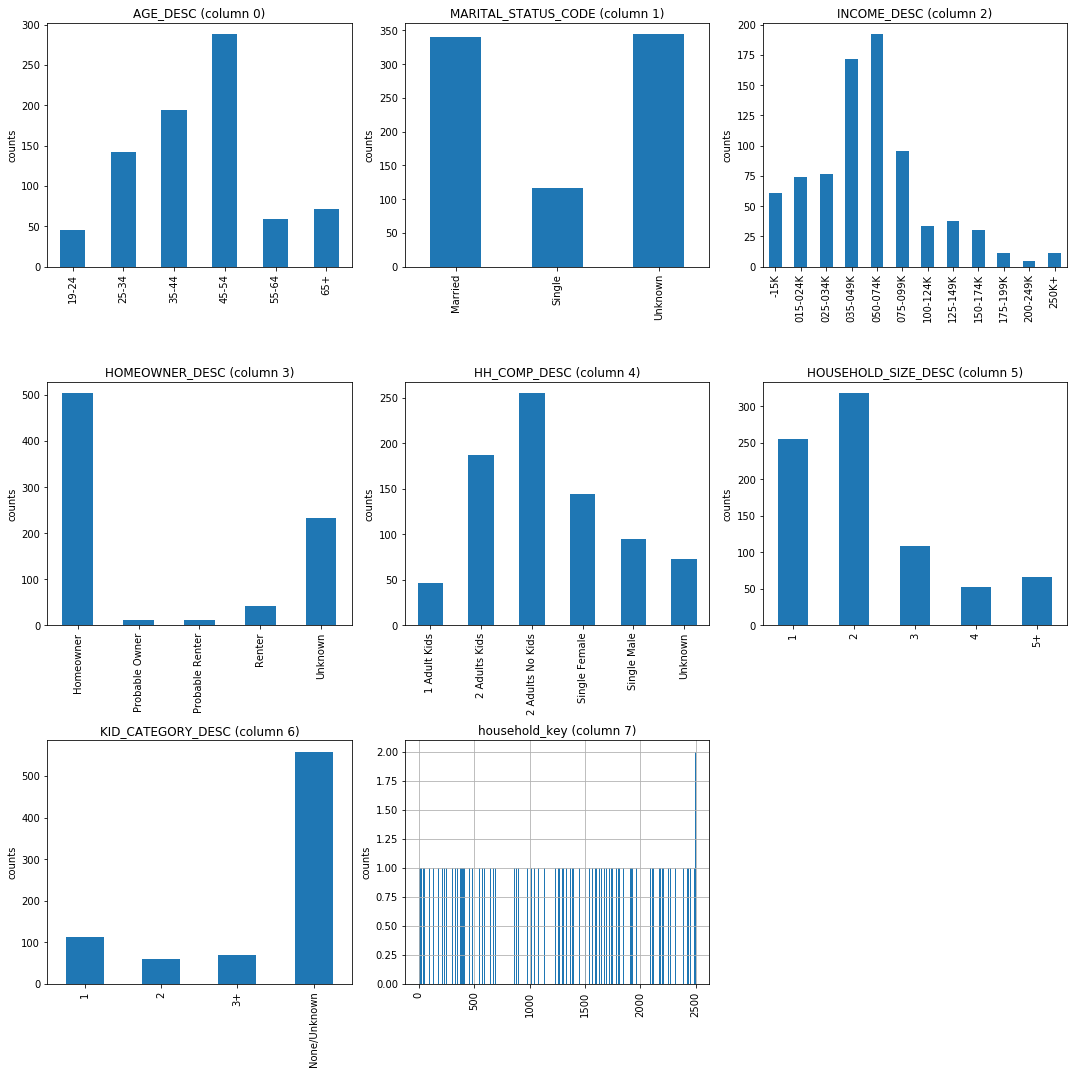

In [11]:
plotDistributionDataset(demographic)

_**Comments:**
As we said previously, we use `Household Composition` and `Household Size` to replace the unknown values of `Marital Status`. Indeed, since these information are conceptually linked, we could infer from one the value of the other. We implemented a rule based function called `replace_unknowns()` that assigns a class to the marital status depending on the values of household composition and size. We consider 2 adults with kids as married, 1 adult with kids as single, single male/female as single, and if size is 1 we also assign single.<br>
We can see that have been able to reduce the number of Uknown values from 344 to 95. We won't drop the remaining Unknowns  since we intend to use mainly income, age and composition information, and we don't want to lose that rows._

In [12]:
demographic.MARITAL_STATUS_CODE = demographic.apply(lambda row: replace_unknowns(row['HH_COMP_DESC'],
                                                    row['MARITAL_STATUS_CODE'], row['HOUSEHOLD_SIZE_DESC']),axis=1)

In [13]:
demographic.MARITAL_STATUS_CODE.value_counts()

Married    383
Single     323
Unknown     95
Name: MARITAL_STATUS_CODE, dtype: int64

_**Comments:**<br>
Now we try to take a look at the dependancy between our features. We start by one hot encoding our features since they are categorical.Then plot a correlation heatmap to compare features. We observe the following:_
- _There is a relatively high correlation between marital status and the household size, which is expectable since mainly married couples would have a household size of more than 2. We also observe that households labeled single tend to have a size of 1._
- _There is a high correlation between marital status and homeownership status. We can see that married couples tend to possess the ownership of their house, while singles are mostly renters or with unknow ownership status._
- _Marital status shows also some correlation with the income. Married couples tend to have a high income ranging from 75K to +250K, while singles tend to have a lower income ranging from under 15K to 34K._
- _We could also observe a slight correlation between the age feature and the income. Household with le lowest age range 19-24 yo seem to be the ones with the highest income +250K but also with the lowest one under 15K. While the other classes of age up until 64 yo seem to have an income ranging between 50K and 199K. A higher age seems to be correlated with a lower income of 35K-49K._

In [14]:
one_hot_demographic = pd.get_dummies(demographic, columns=['AGE_DESC', 'MARITAL_STATUS_CODE', 'INCOME_DESC', 'HOMEOWNER_DESC', 
                                                           'HH_COMP_DESC', 'HOUSEHOLD_SIZE_DESC', 'KID_CATEGORY_DESC'])

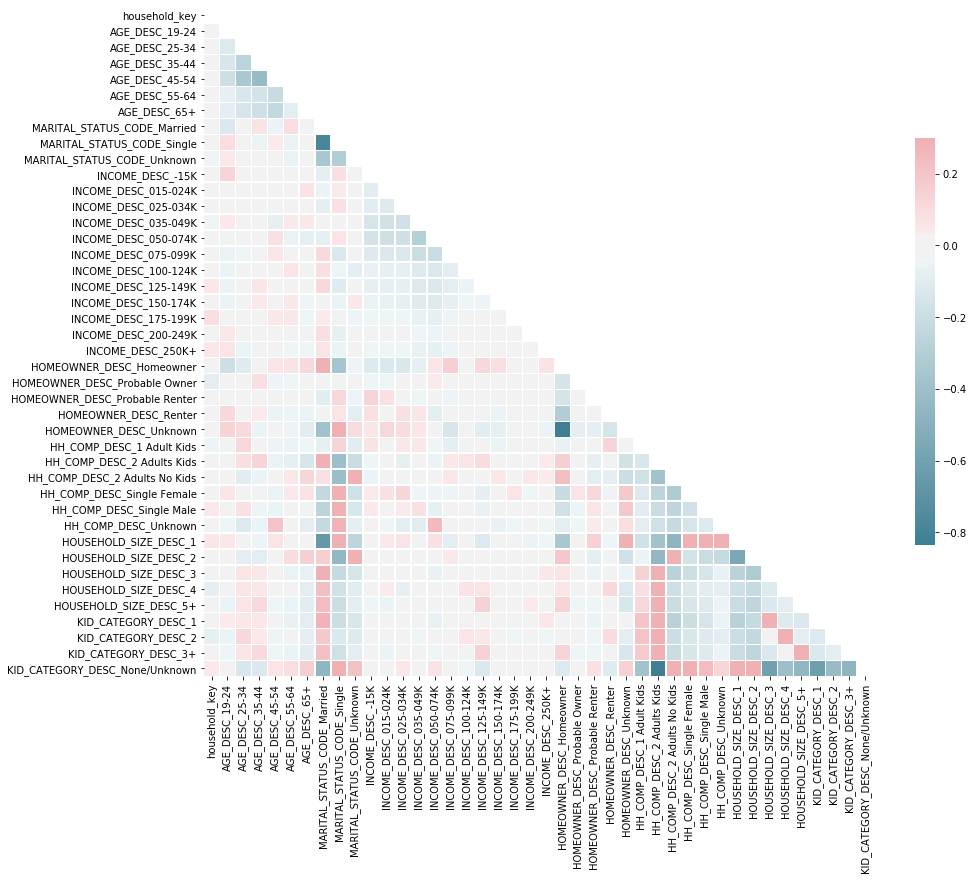

In [15]:
corr = one_hot_demographic.corr(method = 'pearson')
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
fig, ax = plt.subplots(figsize=(15,15))         # Sample figsize in inches
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

#### **A2. Transactions Analysis:**

_**Comments:** <br>
The transaction data subdataset contains all the purchases made by households within the study.This table is transaction centered, it essentially provides for each transaction the ID of the household which bought it, the product ID, the quantity bought, the sales value which is the margin gained by the retailer, as well as the transaction time, day and week._

In [17]:
transaction = pd.read_csv('/media/florian/Data/Datasets/ADA/dunnhumby/transaction_data.csv', delimiter=',')
print(f'The number of rows and columns in the dataframe is respectively {transaction.shape[0]} and {transaction.shape[1]}')
transaction.head()

The number of rows and columns in the dataframe is respectively 2595732 and 12


,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


_**Comments:**<br>
Since we saw in the demographic analysis that the first subdataset doesn't include all the household IDs. It is pertinant to keep the transactions made by households with provided demographic data only, thus the following._

In [18]:
demographic_households = demographic.household_key.unique()
transaction = transaction[transaction.household_key.apply(lambda x: x in demographic_households)]
print(f'The number of rows and columns in the dataframe now is now respectively {transaction.shape[0]} and {transaction.shape[1]}')

The number of rows and columns in the dataframe now is now respectively 1427303 and 12


_**Comments:**<br>
This dataset details all the transactions made by each household. Therefore, it gives information on their consumption over time. Using the custom function to plot the distributions of each feature, we get the following plots and observations:_
- _`Week_no` : This feature specifies the week during which the transaction has been made. It ranges from 0 to 102. We can see that the consumption starts low in the first weeks, and increases rapidly to reach a trend plateau of approcimately 28000 transactions per week. Also we notice that in the last week, consumption explodes to nearly 50000 transctions. To keep the data uniform and have a fixed consumption over the weeks, we intend to drop the transactions made during the first and last weeks._
- _`Transaction Time` : This feature provides the time during the day at which the transaction has been made. It ranges from 0 to 2400, corresponding to the 24 hours of the day. We can see that most of the transactions are made during the day between 10:00 and 22:00, with a maximum of consumption at 18:00._
- _`Day`: This feature specifies in which day the transaction has been made. It just gives a more precise date than the week_no attribute. As in this latter, we can see that there is a low consumption during the first days increasing to reach a plateau of approximately 4000 transactions per day. Since this feature represents a higher time resolution, we will drop the transactions made in the first and last few days to make the data more uniform over time._
_The custom function does not give correct plots for the features `QUANTITY` and `SALES_VALUE`, because the distributions of these attributes are extremely skewed, this is why we plot them separatly. We obseve the following:_
- _`Quantity` : This feature gives the quantity of the product bought at each transaction. It is heavy tailed with value that reach more than 89000. However most of the values are between 0 and 10._ 
- _`Sales value` : This attribute reprensents the margin gained by the retailer in the transaction. The price of the product could be derived from this value, which we'll do later. It is also highly skewed but most values range between 0 and 20._

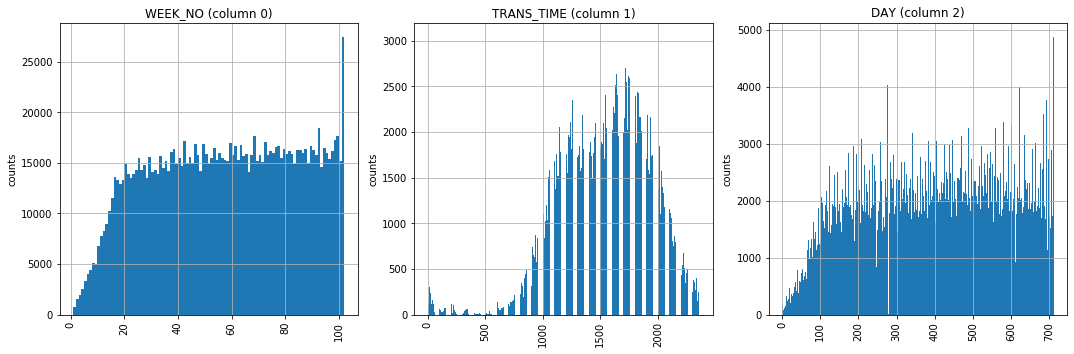

In [19]:
plotDistributionDataset(transaction.loc[:,['WEEK_NO','TRANS_TIME','DAY']])

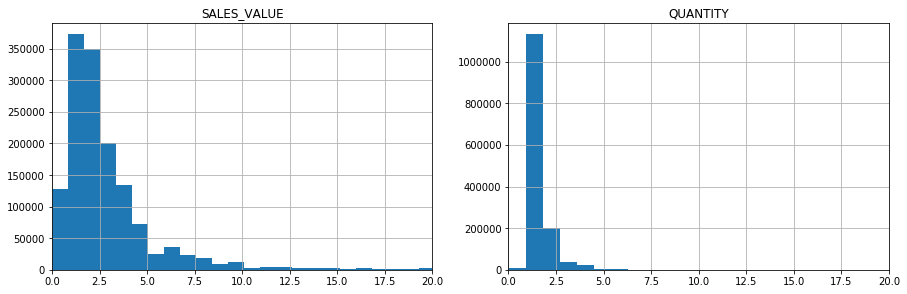

In [20]:
plt.figure(num = None, figsize = (15,10))
plt.subplot(2,2,1)
ax1 = transaction.SALES_VALUE.hist(bins=1000)
ax1.set_xlim(0,20)
plt.subplot(2,2,2)
ax2 = transaction.QUANTITY.hist(bins=100000)
ax2.set_xlim(0,20)
ax1.title.set_text('SALES_VALUE')
ax2.title.set_text('QUANTITY')
plt.show()

_**Comments:**<br>
We plot a heatmap of the correlations between the transaction features, we observe the following:_
- _Most of the high correlations we observe are expected for example between 'Day' and 'Week_No', 'Quantity' and 'Sales value'._
- _We observe a slightly high correlation between the product ID and Quantity, as well as with the sales value._

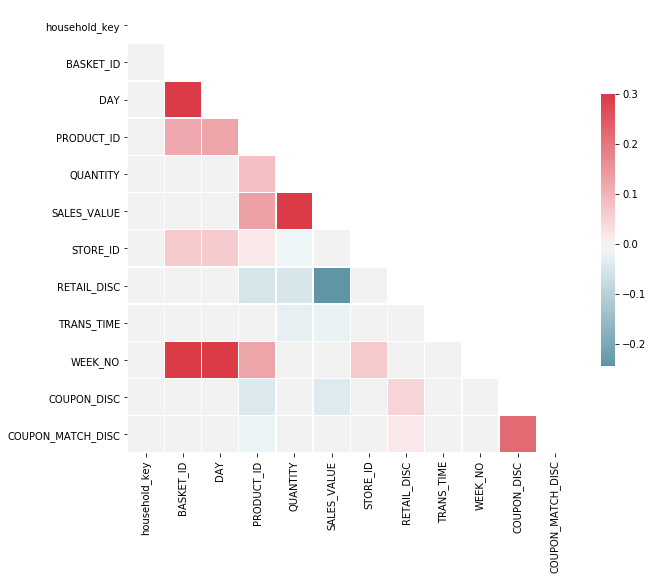

In [21]:
corr = transaction.corr(method = 'pearson')
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

_**Comments:**<br>
For further use, we divide the Sales value feature into two different columns, one where we keep the actual sales value, and the other where we sum all the sales values of transactions made by a household during the whole study, resulting in an indicator of the total money spent by the household during the period of the study._

In [22]:
behavior_consumer = pd.DataFrame(transaction.groupby(['household_key']).sum().SALES_VALUE)
behavior_consumer['SALES_VALUE_TOTAL'] = behavior_consumer['SALES_VALUE']
behavior_consumer = behavior_consumer.drop(columns=['SALES_VALUE'])
transaction = pd.merge(transaction, behavior_consumer, on='household_key')
transaction.head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC,SALES_VALUE_TOTAL
0,1364,26984896261,1,842930,1,2.19,31742,0.00,1520,1,0.0,0.0,2466.05
1,1364,26984896261,1,897044,1,2.99,31742,-0.40,1520,1,0.0,0.0,2466.05
2,1364,26984896261,1,920955,1,3.09,31742,0.00,1520,1,0.0,0.0,2466.05
3,1364,26984896261,1,937406,1,2.50,31742,-0.99,1520,1,0.0,0.0,2466.05
4,1364,26984896261,1,981760,1,0.60,31742,-0.79,1520,1,0.0,0.0,2466.05


#### **A3. Products Analysis:**

_**Comments:** <br>
The products subdataset contains the list of products purchased by households during the study. It gives information about each product sold as type of product,national or private label and brand identifier. The main goal of the project is to analyse people's food consumption, we limited our analysis on food related product ('list_food'). We plot the distributions of each feature, we get the following plots and observations:_
- _`DEPARTMENT` : Groups similar products together, the majority of product sold where in the Grocery departement. It has 10 unique classes._ 
- _`BRAND` : Indicates Private or National label brand, the large majority of product sold came from national brands._ 
- _`COMMODITY_DESC` : Groups similar products together at a lower level. It provides 183 types of commodities (Soft drinks, bag snacks, frozen meat ...)_
- _`SUB_COMMODITY_DESC` : Groups similar products together at the lowest level. It has 1319 classes (potato chips, spices and seasoning, beermalt liquors ...)_

In [23]:
product = pd.read_csv('/media/florian/Data/Datasets/ADA/dunnhumby/product.csv', delimiter=',')
print(f'There are {product.shape[0]} rows and {product.shape[1]} columns')
product.head()

There are 92353 rows and 7 columns


,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ


_**Comments:**<br>
We take a look at the distributions of the features `Department` and `Brand` since they have a limisted number of classes. We notice that most of the products correspond to the class 'Grocery', with a value count of nearly 40000, while the other classes contain less than 5000 products each. Also, we observe that more than 40000 products are labeled as 'National' while only 1000 are labeled as private. <br>
Since the subdataset contains not only food related products we decided to drop some of them based on the department class. We only keep the departments mentioned in the list below called 'list_food'._

There are now 51331 rows and 7 columns


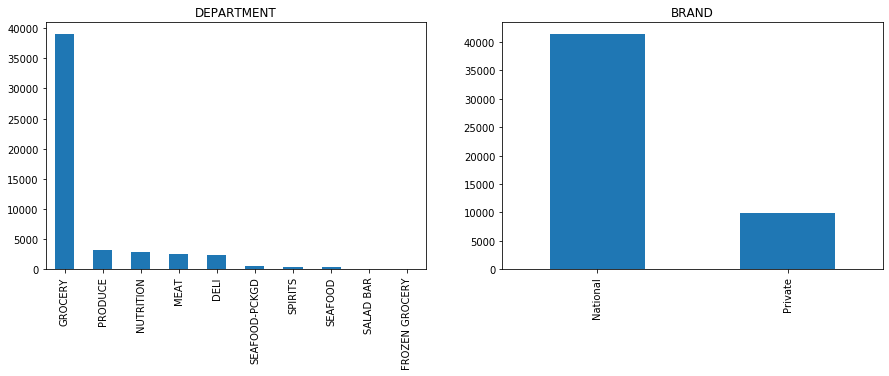

In [24]:
list_food = ['GROCERY','PASTERY','PRODUCE','NUTRITION','MEAT','FROZEN GROCERY','SALAD BAR','SEAFOOD','SPIRITS','SEAFOOD-PCKGD','MEAT-PCKG','DELI'] 
food_related_products = product[product.DEPARTMENT.apply(lambda x: x in list_food)]
print(f'There are now {food_related_products.shape[0]} rows and {food_related_products.shape[1]} columns')

plt.figure(num = None, figsize = (15,10))
plt.subplot(2,2,1)
ax1 = food_related_products.DEPARTMENT.value_counts().plot.bar()
plt.subplot(2,2,2)
ax2 = food_related_products.BRAND.value_counts().plot.bar()
ax1.title.set_text('DEPARTMENT')
ax2.title.set_text('BRAND')
plt.show()

### **B. Merged Dataset Analysis:**

#### **B1. Merging subsets:**

_**Comments:** <br>
In order to simplify the analysis of the dataset, we decided to merge the 3 subdatasets. We first drop the unwanted features from the subsets, then we merge the food related products and transactions subsets based on the product id. After that, we merge this new intersection dataset with the demographic subset based on the Houselhold key. Both mergers are made as an 'inner' join of subsets. <br>
The new dataset contains all the features. It is household centric, for each household we have the informations on the consumed products as well as on the purchase which makes the analysis simpler._

In [25]:
food_related_products.drop(columns = ['BRAND','CURR_SIZE_OF_PRODUCT','MANUFACTURER'],inplace = True)
consumution = transaction.drop(columns = ['STORE_ID','RETAIL_DISC','TRANS_TIME','COUPON_DISC','COUPON_MATCH_DISC'])
inter = pd.merge(food_related_products,consumution,on =  'PRODUCT_ID')
full_data_set = pd.merge(inter,demographic,on = 'household_key')
full_data_set.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,PRODUCT_ID,DEPARTMENT,COMMODITY_DESC,SUB_COMMODITY_DESC,household_key,BASKET_ID,DAY,QUANTITY,SALES_VALUE,WEEK_NO,SALES_VALUE_TOTAL,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC
0,25671,GROCERY,FRZN ICE,ICE - CRUSHED/CUBED,1228,29046618323,157,1,3.49,23,14503.89,45-54,Single,100-124K,Unknown,Single Female,1,None/Unknown
1,43266,GROCERY,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1228,29513525602,187,1,0.89,27,14503.89,45-54,Single,100-124K,Unknown,Single Female,1,None/Unknown
2,68543,GROCERY,DOG FOODS,CAN DOGFD GOURMET/SUPER PREM (,1228,31841925002,325,1,0.69,47,14503.89,45-54,Single,100-124K,Unknown,Single Female,1,None/Unknown
3,71759,GROCERY,FROZEN PIE/DESSERTS,FRZN WHIPPED TOPPING,1228,30589276083,235,1,0.69,34,14503.89,45-54,Single,100-124K,Unknown,Single Female,1,None/Unknown
4,73580,GROCERY,ICE CREAM/MILK/SHERBTS,QUARTS,1228,28394445201,117,1,4.99,17,14503.89,45-54,Single,100-124K,Unknown,Single Female,1,None/Unknown


#### **B2. Relevant correlations analysis:**

_**Comments:**<br>
We try to take a look at relevant coorelations between the features that have been brought together in the new dataset. We decide to first evaluate the influence of income and age on the consumed products as well as the total spent money. We start by one hot encoding the feature `Income` then we plot a heatmap of the correlations, we observe the following:_
- _Most of the high correlations are between high incomes and total money spent during the study ('sales_value_y') ._
- _We observe a slightly negative correlation between low incomes and total money spent during the study ('sales_value_y')._
_The more money we make,the more we spend on food._

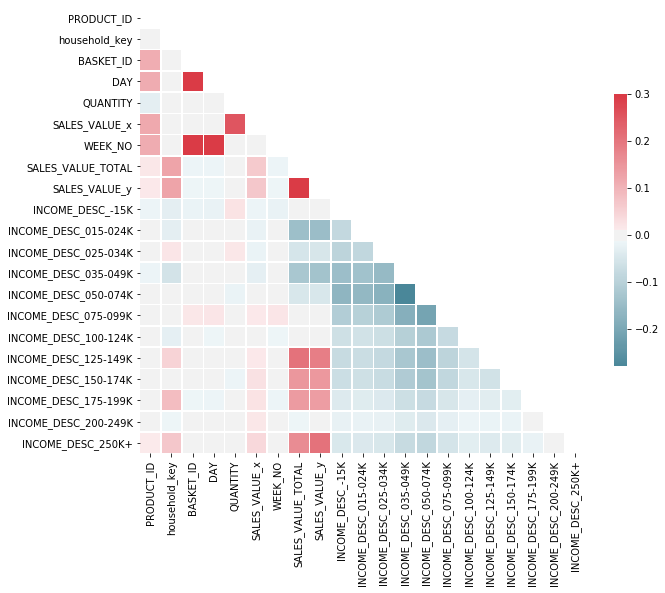

In [28]:
full_data_set_test = pd.merge(full_data_set,behavior_consummer,on = 'household_key')
one_hot_income = pd.get_dummies(full_data_set_test, columns=["INCOME_DESC"])
corr = one_hot_income.corr(method = 'pearson')

corr.SALES_VALUE_y.sort_values(ascending = False)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

_**Comments:**<br>
Now we do the same but with the `AGE` feature, in orther to evaluate correlations between age and consumed products and their sales value, we observe that:_
- _There is a relatively high correlation between ages in the range 35-54 yo with the total sales value (total money spent)._
- _The other age categories are slightly negatively correlated with the total sales value._
_The more money we make,the more we spend on food._

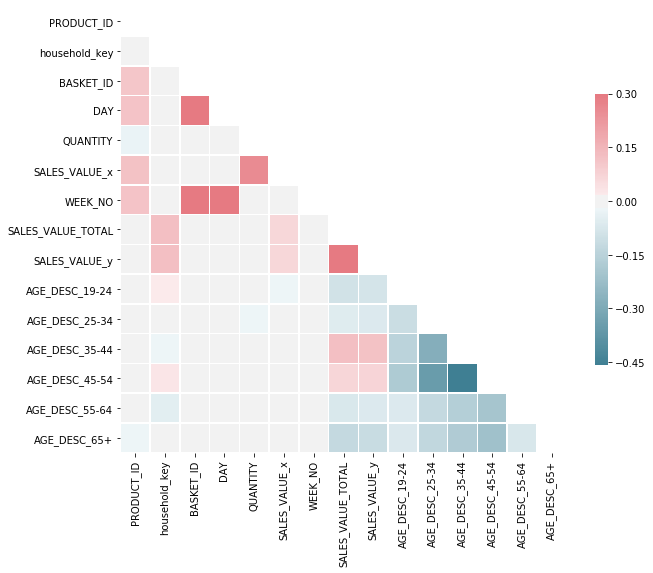

In [27]:
behavior_consummer = full_data_set.groupby(['household_key']).sum().SALES_VALUE
full_data_set_test = pd.merge(full_data_set,behavior_consummer,on = 'household_key')
one_hot_income = pd.get_dummies(full_data_set_test, columns=["AGE_DESC"])
corr = one_hot_income.corr(method = 'pearson')

corr.SALES_VALUE_y.sort_values(ascending = False)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

#### **B3. Influence of Income and AGE on food consumption:**

_**Comments:**<br>
From the correlations previously computed, we noticed that there is some influence of the age and income of the household on their choice of food products depending on their sales value. We want to inspect more this influence by looking at which foods are common to most of income classes and age categorie, and which ones are specific to each class. This would help us analyse the disparity of food consumption between social classes with the income and age as social indicators.<br>_

_**Comments:**<br>
For the income:<br>_
_-We stated by computing the ten most consumed products for each category of income and then classified them as ‘common foods’ for all categories or ‘specific foods’.<br>_

_In order to classify them as common foods, the product needs to be consumed by at least half of all income categories. Moreover, to classify them as specific foods, the product needs to be consumed by at most two different income categories.<br>_
_-Results for common foods:  From the plot, we can say that every class consumed 6 items (‘bananas’,’ yogurt ’,’ bread ’,’ milk ’,’ soft drinks’, ‘cheese’). This six items are considered as commodities necessary for a balanced diet. Furthermore, this items are consumed in almost the same quantity for all the categories.<br>_
_-Results for specific food products: the results are more significant in this case, lower income categories consumed mainly base products. And higher incomes categories consumed more exotic food and healthy food such as strawberries, soup, premium food, 100% fruit juice._

                                -15K  015-024K  025-034K  035-049K  050-074K  \
BANANAS                            2         1         1         1         1   
FLUID MILK WHITE ONLY              3         3         2         2         3   
SHREDDED CHEESE                    1         1         1         1         1   
YOGURT NOT MULTI-PACKS             4         2         1         1         1   
MAINSTREAM WHITE BREAD             0         0         1         1         0   
SOFT DRINKS 12/18&15PK CAN CAR     1         1         1         2         1   
SFT DRNK 2 LITER BTL CARB INCL     0         1         1         2         1   

                                075-099K  100-124K  125-149K  150-174K  \
BANANAS                                1         1         1         1   
FLUID MILK WHITE ONLY                  2         3         2         2   
SHREDDED CHEESE                        1         1         1         1   
YOGURT NOT MULTI-PACKS                 2         1         1   

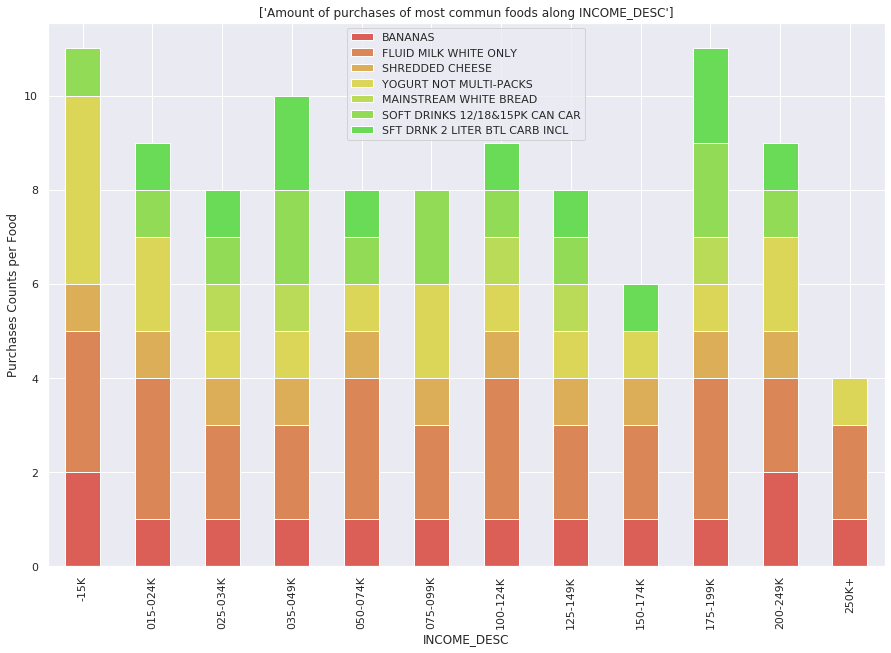

                                -15K  015-024K  025-034K  035-049K  050-074K  \
ADULT CEREAL                       0         0         0         0         0   
MIXERS(CLUB SODA/SELTZERS)FLAV     0         0         0         0         0   
SFT DRNK SNGL SRV BTL CARB (EX     0         0         0         0         0   
YOGURT MULTI-PACKS                 0         0         0         0         0   
STRAWBERRIES                       0         0         0         0         0   
KIDS CEREAL                        0         0         0         0         0   
PREMIUM                            0         0         0         0         0   
DAIRY CASE 100% PURE JUICE - O     0         0         0         0         0   
POPULAR 750ML WINES                0         0         0         0         0   
RTS SOUP: CHUNKY/HOMESTYLE ET      0         0         0         0         0   
BEERALEMALT LIQUORS                0         0         0         0         0   
CAN CATFD GOURMET/SUP PREM (GR     0    

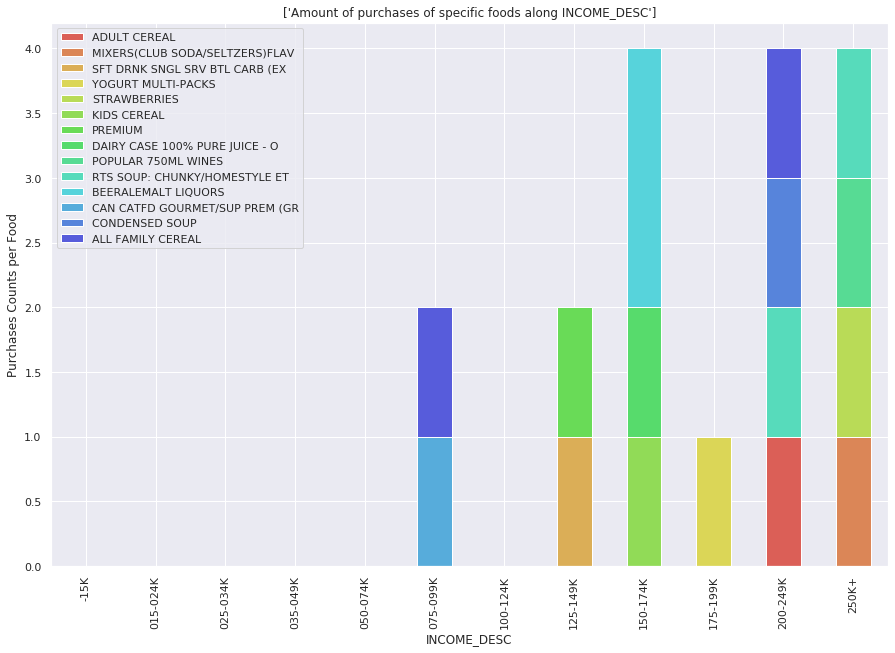

In [41]:
ploting_specific_general(full_data_set,'INCOME_DESC')

_**Comments:**<br>
For the age:<br>_
_-We stated by computing the ten most consumed products for each category of age and then classified them as ‘common foods’ for all categories or ‘specific foods’.<br>_
_In order to classify them as common foods, the product needs to be consumed by at least half of all age categories. Moreover, to classify them as specific foods, the product needs to be consumed by at most two different age categories.<br>_
_-Results for common foods:  From the plot, we can say that every class consumed 6 items (‘bananas’,’ yogurt ’,’ bread ’,’ milk ’,’ soft drinks’, ’cheese’). This six items are considered as commodities necessary for a balanced diet. Furthermore, this items are consumed in almost the same quantity for all the categories. We also have a new item that is ‘Potato chips’, that is mainly consumed by this two categories of age : ’19-24’,’25-34’.<br>_
_-Results for specific food products: the results are much more interesting than before, each age category, consumes different products :’45-54’ consumes as necessary ‘beer’, the'50-64’ categori consumes ‘Kids cereal’ meaning that they have children’s but, there was no visible correlation between the this category of age and kids, they also consumes ‘Economy dinners’.Finaly,the ‘65+‘ category are healthier and consumed more healthier food 100% fruit juice._

                                19-24  25-34  35-44  45-54  55-64  65+
BANANAS                             1      1      2      1      1    1
FLUID MILK WHITE ONLY               3      2      3      3      2    3
SHREDDED CHEESE                     1      1      0      1      1    1
YOGURT NOT MULTI-PACKS              1      1      1      2      1    2
MAINSTREAM WHITE BREAD              1      1      1      1      1    1
SOFT DRINKS 12/18&15PK CAN CAR      1      1      1      1      2    1
SFT DRNK 2 LITER BTL CARB INCL      1      1      1      1      3    1
POTATO CHIPS                        1      1      0      0      1    0


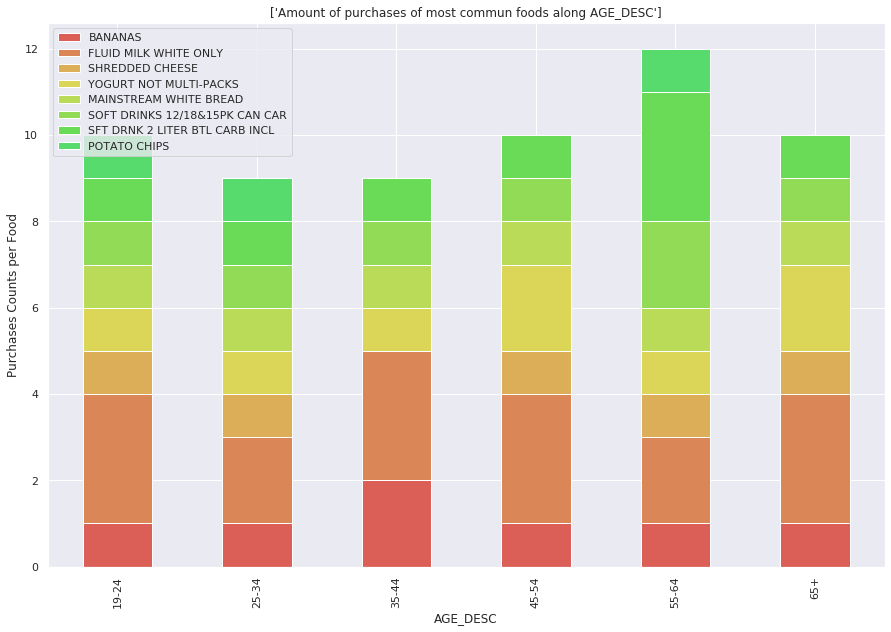

                                19-24  25-34  35-44  45-54  55-64  65+
SS ECONOMY ENTREES/DINNERS ALL      0      0      0      0      1    0
KIDS CEREAL                         0      0      0      0      1    0
RTS SOUP: CHUNKY/HOMESTYLE ET       0      0      1      0      1    0
BEERALEMALT LIQUORS                 0      0      0      1      0    0
CONDENSED SOUP                      0      0      1      0      0    0
DAIRY CASE 100% PURE JUICE - O      0      0      1      0      0    1


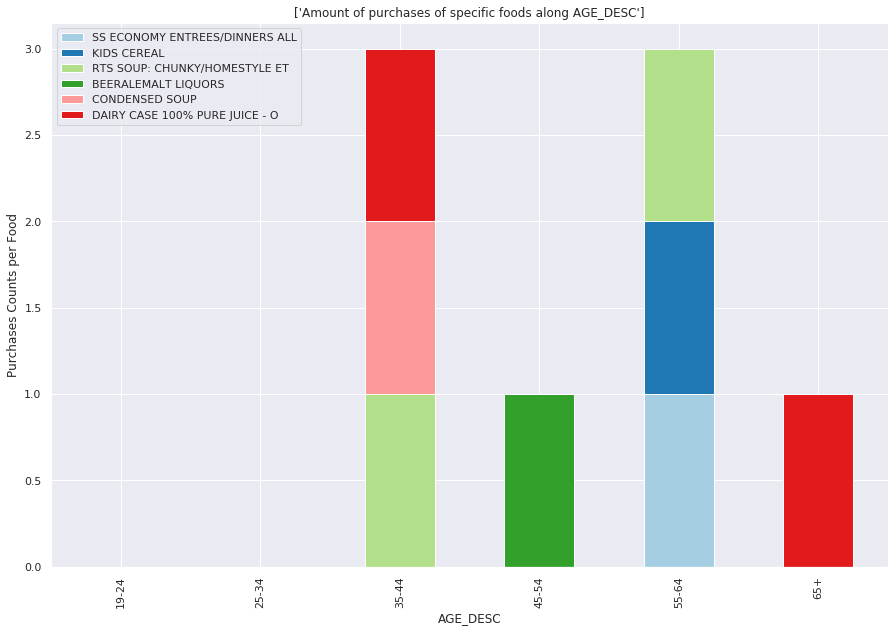

In [42]:
ploting_specific_general(full_data_set,'AGE_DESC')

_**Comments:**<br>
For the marital status,We observe the same status as before._

                                Married  Single  Unknown
BANANAS                               1       1        1
FLUID MILK WHITE ONLY                 2       3        3
SHREDDED CHEESE                       1       1        1
YOGURT NOT MULTI-PACKS                1       2        1
MAINSTREAM WHITE BREAD                1       1        1
SOFT DRINKS 12/18&15PK CAN CAR        1       1        2
SFT DRNK 2 LITER BTL CARB INCL        1       1        1
POTATO CHIPS                          1       0        1
CONDENSED SOUP                        0       0        0


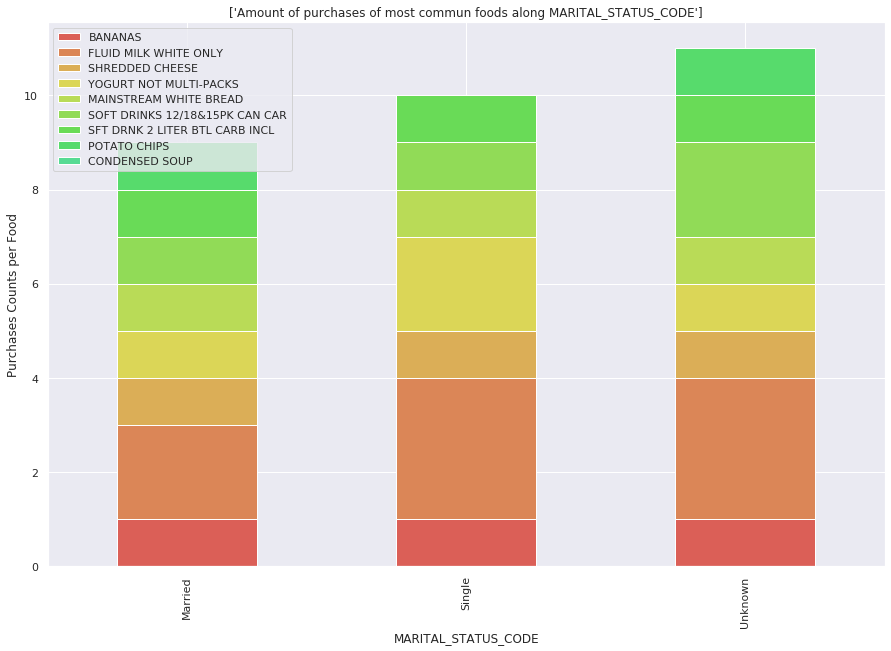

                                Married  Single  Unknown
FRZN SS PREMIUM ENTREES/DNRS/N        0       0        1


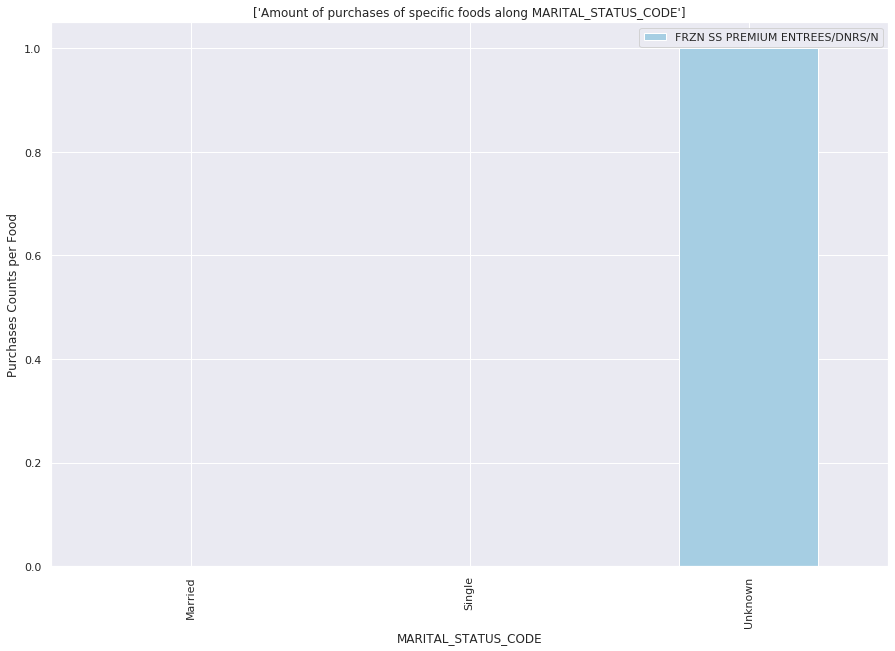

In [43]:
ploting_specific_general(full_data_set,'MARITAL_STATUS_CODE')

### **C. Conclusions:**

The Dunhumby dataset gives us valuable demographic information but also informations on how people consume and what they consume.
With this dataset we were able to evaluate the social status of each household,and correlate this information with their food consumption.

### **=====================================================================================**

# **PART 2 : &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Open Food Fact Analysis**

## **Introduction :**
The Open Food Fact is a collaborative dataset of food products from arount the world, with ingredients, allergens, nutrition facts and all information we can find on product labels.
Open Food Facts Database is a 2.1GB CSV file with tab separators. We will use the folowing features for our analysis :<br>

- Nutrition: features related to nutriements<br>
- Ingredients: features about composition of the food <br>
- Tag: information about product_name, countries etc...

In [169]:
import pandas as pd
import numpy as np
import re
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
from sklearn import manifold, datasets
from adjustText import adjust_text
import math

In [198]:
def highlight(f, n_labels, size=(10,10)):
    x, y = Y.T
    names = df_nutrition.product_name[X.index]
    names_list = names.tolist()
    colors = names.apply(lambda s: 'red' if f(s) else 'lightgray').tolist()
    
    fig, ax = plt.subplots(figsize=size)

    sc = plt.scatter(x, y, c=colors, s=5)
    
    texts = [plt.text(x[i], y[i], names_list[i], fontsize=10) for i in np.random.choice(len(X), n_labels)]
    adjust_text(texts)

    plt.show()

In [195]:
def highlight2(cols, title, size=(10,10)):
    x, y = Y.T
    
    def exists_col(r):
        for c in cols:
            if r[c] == 1:
                return True
        return False
    
    colors = matrix.loc[X.index.intersection(matrix.index)].apply(lambda r: 'red' if exists_col(r) else 'lightgray', axis=1).tolist()
    
    fig, ax = plt.subplots(figsize=size)

    plt.axis('off')
    
    sc = plt.scatter(x, y, c=colors, s=5)
    
    texts = [plt.text(x[i], y[i], names_list[i], fontsize=7) for i in np.random.choice(len(X), 0)]
    adjust_text(texts)

    plt.title(title)
    
    plt.show()

In [173]:
openfoodfacts = pd.read_csv('data/dataset_open_food.csv','\t')
print('Shape of the dataset:',openfoodfacts.shape)

#openfoodfacts.head() --> for the moment

C:\Users\smail\Anaconda3\envs\ada\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (0,24,25,26,28,44,49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Shape of the dataset: (1005487, 175)


,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,0000000000017,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1529059080,2018-06-15T10:38:00Z,1561463718,2019-06-25T11:55:18Z,Vitória crackers,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000000031,http://world-en.openfoodfacts.org/product/0000...,isagoofy,1539464774,2018-10-13T21:06:14Z,1539464817,2018-10-13T21:06:57Z,Cacao,NaN,130 g,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00000000001111111111,http://world-en.openfoodfacts.org/product/0000...,openfoodfacts-contributors,1560020173,2019-06-08T18:56:13Z,1560020173,2019-06-08T18:56:13Z,Sfiudwx,NaN,dgesc,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0000000000123,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1535737982,2018-08-31T17:53:02Z,1535737986,2018-08-31T17:53:06Z,Sauce Sweety chili 0%,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0000000000178,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1542456332,2018-11-17T12:05:32Z,1542456333,2018-11-17T12:05:33Z,Mini coco,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## **A. Cleaning the dataset:**

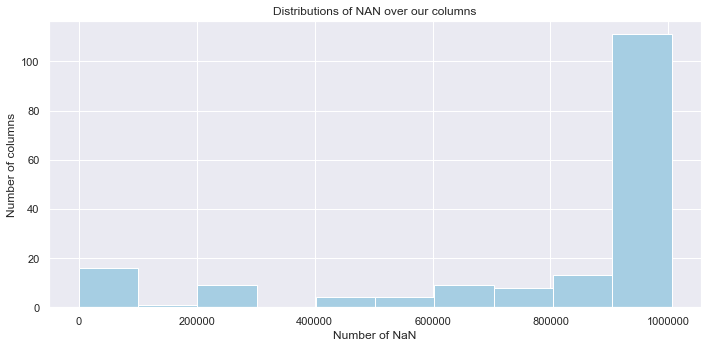

In [174]:
nan_column = openfoodfacts.isnull().sum(axis=0).sort_values(ascending=False)
plt.figure(figsize=(10,5))
plt.title('Distributions of NAN over our columns')
nan_column.hist(bins='auto')
plt.xlabel('Number of NaN')
plt.ylabel('Number of columns')
plt.tight_layout()
plt.show()

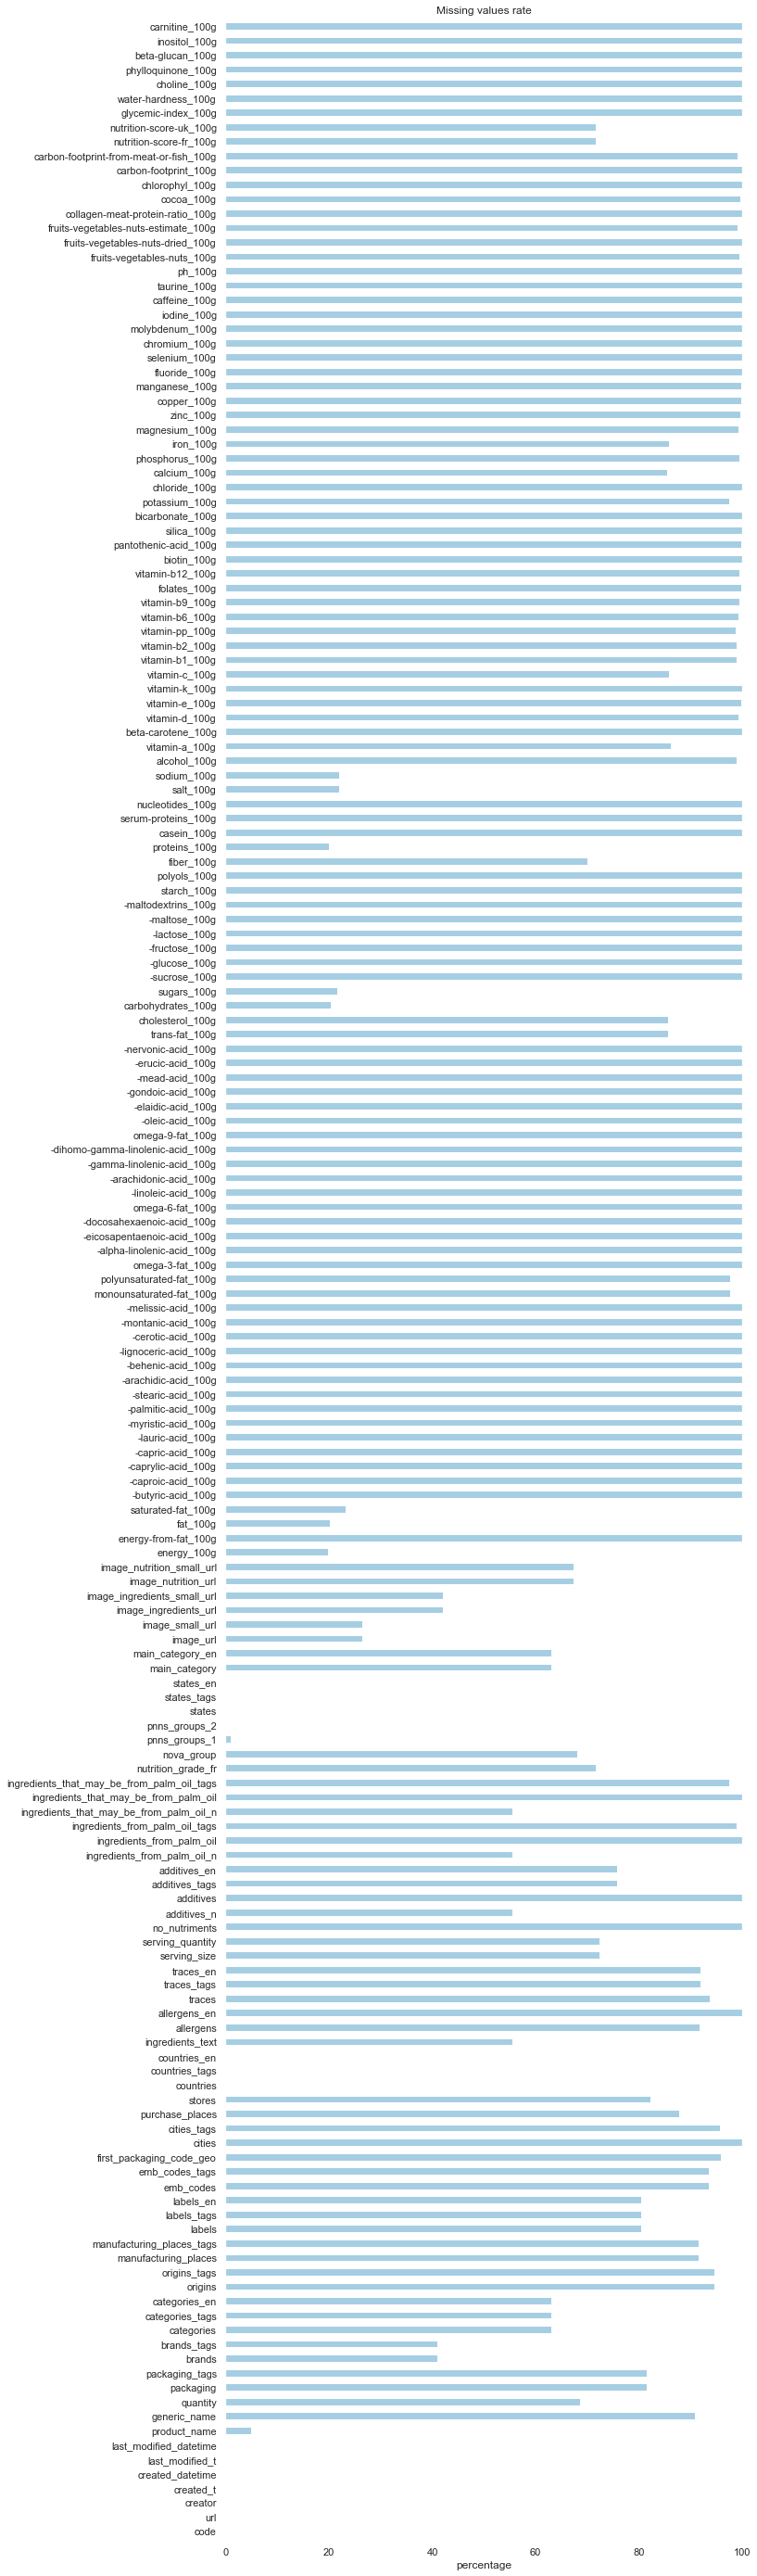

In [209]:
plt.figure(figsize=(10, 50))
plt.rcParams['axes.facecolor'] = 'white'
plt.rc('grid')
(openfoodfacts.isnull().mean(axis=0)*100).plot.barh()
plt.xlim(xmax=100)
plt.title("Missing values rate")
plt.xlabel("percentage")
plt.show();

**Comments: (to be moved down)**<br>
_Furthermore, there are some missing values in the dataset. Actually some of these columns are nearly empty, for example the composition columns ("cocoa_100g", "zinc_100g", etc...). But this can easily be explained by the fact that it is impossable to put on every product's label its complete composition._

_Moreover, we can choose to discard features with more than 60% missing values (for instance), because these features are inconsistent. However, we do not want to do that because in the following parts, we are going to discuss some specific aspects of our food activity :_
   - _Additives_
   - _Allergens_
   - _Palm Oil_

_These are some negative aspects of our food consumption, and we are going to study these aspects in regard of the french food nutrition grade (given in many countries).
Specifically, we are going to study the World and US consumptions concerning these aspects._

_**Comments:**<br>
We focus our analysis on American products,this is a decision we made in order to complete the Dunhumby dataset which is the US.
We will focus mainly on the nutrition table below, this will help to correct mistakes in the dataset. By comparing the energy_100g and calculated energy from carbohydrates, proteins and fat, we can delet some wrong entries.
If the sum of element in 100g of product is more than 100g this entry is wrong and can be deleted._

In [216]:
nutrition_table_cols = ["product_name", "ingredients_text", "allergens","energy_100g",
                        "fat_100g",
                        "carbohydrates_100g",
                        "sugars_100g",
                        "proteins_100g",
                        "salt_100g",
                        "allergens",
                        "ingredients_from_palm_oil",
                       "additives","countries_en",
                       "nutrition_grade_fr","additives_tags"]

In [217]:
df_nutrition = openfoodfacts[nutrition_table_cols].copy()
interest = df_nutrition.product_name.dropna().index.intersection(df_nutrition.ingredients_text.dropna().index)
interest = interest.intersection(df_nutrition[df_nutrition.countries_en == "United States"].index)
df_nutrition = df_nutrition.iloc[interest]
df_nutrition.head()

,product_name,ingredients_text,allergens,energy_100g,fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,allergens,ingredients_from_palm_oil,additives,countries_en,nutrition_grade_fr,additives_tags
42,Banana Chips Sweetened (Whole),"Bananas, vegetable oil (coconut oil, corn oil ...",NaN,2243.0,28.57,64.29,14.29,3.57,0.00000,NaN,NaN,NaN,United States,NaN,NaN
43,Peanuts,"Peanuts, wheat flour, sugar, rice flour, tapio...",NaN,1941.0,17.86,60.71,17.86,17.86,0.63500,NaN,NaN,NaN,United States,NaN,NaN
92,Organic Salted Nut Mix,"Organic hazelnuts, organic cashews, organic wa...",NaN,2540.0,57.14,17.86,3.57,17.86,1.22428,NaN,NaN,NaN,United States,NaN,NaN
93,Organic Polenta,Organic polenta,NaN,1552.0,1.43,77.14,NaN,8.57,NaN,NaN,NaN,NaN,United States,NaN,NaN
94,Breadshop Honey Gone Nuts Granola,"Rolled oats, grape concentrate, expeller press...",NaN,1933.0,18.27,63.46,11.54,13.46,NaN,NaN,NaN,NaN,United States,NaN,NaN


In [218]:
df_nutrition["sum_elements"] = df_nutrition.fat_100g + df_nutrition.carbohydrates_100g +\
                            df_nutrition.proteins_100g

df_nutrition["sum_elements"] = round(df_nutrition.sum_elements)

df_nutrition["other_carbs"] = df_nutrition.carbohydrates_100g - df_nutrition.sugars_100g

df_nutrition["reconstructed_energy"] = df_nutrition.fat_100g * 37 + \
                                            (df_nutrition.proteins_100g + df_nutrition.carbohydrates_100g)* 17
df_nutrition.head()

,product_name,ingredients_text,allergens,energy_100g,fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,allergens,ingredients_from_palm_oil,additives,countries_en,nutrition_grade_fr,additives_tags,sum_elements,other_carbs,reconstructed_energy
42,Banana Chips Sweetened (Whole),"Bananas, vegetable oil (coconut oil, corn oil ...",NaN,2243.0,28.57,64.29,14.29,3.57,0.00000,NaN,NaN,NaN,United States,NaN,NaN,96.0,50.00,2210.71
43,Peanuts,"Peanuts, wheat flour, sugar, rice flour, tapio...",NaN,1941.0,17.86,60.71,17.86,17.86,0.63500,NaN,NaN,NaN,United States,NaN,NaN,96.0,42.85,1996.51
92,Organic Salted Nut Mix,"Organic hazelnuts, organic cashews, organic wa...",NaN,2540.0,57.14,17.86,3.57,17.86,1.22428,NaN,NaN,NaN,United States,NaN,NaN,93.0,14.29,2721.42
93,Organic Polenta,Organic polenta,NaN,1552.0,1.43,77.14,NaN,8.57,NaN,NaN,NaN,NaN,United States,NaN,NaN,87.0,NaN,1509.98
94,Breadshop Honey Gone Nuts Granola,"Rolled oats, grape concentrate, expeller press...",NaN,1933.0,18.27,63.46,11.54,13.46,NaN,NaN,NaN,NaN,United States,NaN,NaN,95.0,51.92,1983.63


In [219]:
print(df_nutrition.reconstructed_energy.describe())
print('='*40)
print(df_nutrition.energy_100g.describe())
print('='*40)
print(df_nutrition.sum_elements.describe())

count    169282.000000
mean       1146.580820
std         822.046523
min      -13600.000000
25%         354.985000
50%        1153.620000
75%        1700.000000
max       12321.000000
Name: reconstructed_energy, dtype: float64
count    170234.000000
mean       1131.014555
std         980.842778
min           0.000000
25%         360.000000
50%        1142.000000
75%        1674.000000
max      231199.000000
Name: energy_100g, dtype: float64
count    169282.000000
mean         52.870583
std          34.739996
min        -800.000000
25%          19.000000
50%          53.000000
75%          88.000000
max         641.000000
Name: sum_elements, dtype: float64


_**Comments:**
We notice that there are some obvious outliers :<br>_

- _There are some negative values in the calculated energy.<br>_
- _Energy amount exceeding 3700kJ (the maximum energy amount a product can have is 3700kJ and it corresponds to 100% of fat)_
- _The sum of elements (fat_100g,carbohydrates_100g and proteins_100g) is negative in certain case and also higher than 100_

_We can detect the entries that are wrong._

In [220]:
df_nutrition = df_nutrition.loc[df_nutrition.reconstructed_energy<=3700]
df_nutrition = df_nutrition.loc[df_nutrition.reconstructed_energy>0]
df_nutrition = df_nutrition.loc[df_nutrition.sum_elements<=100]
df_nutrition = df_nutrition.loc[df_nutrition.sum_elements>0]
df_nutrition = df_nutrition.loc[df_nutrition.energy_100g>0]
df_nutrition = df_nutrition.loc[df_nutrition.energy_100g<=3700]
df_nutrition.head()

,product_name,ingredients_text,allergens,energy_100g,fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,allergens,ingredients_from_palm_oil,additives,countries_en,nutrition_grade_fr,additives_tags,sum_elements,other_carbs,reconstructed_energy
42,Banana Chips Sweetened (Whole),"Bananas, vegetable oil (coconut oil, corn oil ...",NaN,2243.0,28.57,64.29,14.29,3.57,0.00000,NaN,NaN,NaN,United States,NaN,NaN,96.0,50.00,2210.71
43,Peanuts,"Peanuts, wheat flour, sugar, rice flour, tapio...",NaN,1941.0,17.86,60.71,17.86,17.86,0.63500,NaN,NaN,NaN,United States,NaN,NaN,96.0,42.85,1996.51
92,Organic Salted Nut Mix,"Organic hazelnuts, organic cashews, organic wa...",NaN,2540.0,57.14,17.86,3.57,17.86,1.22428,NaN,NaN,NaN,United States,NaN,NaN,93.0,14.29,2721.42
93,Organic Polenta,Organic polenta,NaN,1552.0,1.43,77.14,NaN,8.57,NaN,NaN,NaN,NaN,United States,NaN,NaN,87.0,NaN,1509.98
94,Breadshop Honey Gone Nuts Granola,"Rolled oats, grape concentrate, expeller press...",NaN,1933.0,18.27,63.46,11.54,13.46,NaN,NaN,NaN,NaN,United States,NaN,NaN,95.0,51.92,1983.63


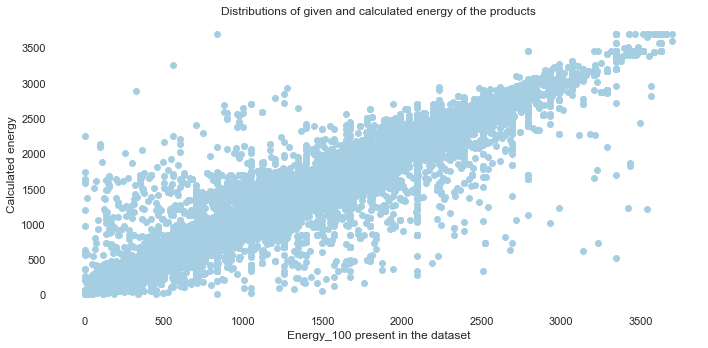

In [221]:
# Visualization of the errors
plt.figure(figsize=(10,5))
plt.title('Distributions of given and calculated energy of the products')
plt.scatter(df_nutrition["energy_100g"], df_nutrition["reconstructed_energy"])
plt.xlabel('Energy_100 present in the dataset')
plt.ylabel('Calculated energy')
plt.tight_layout()
plt.show()

_**Comments:**
The relation between the calculated energy is linearly correlated with the given energy.The cleaning process is succesful for this part._

##  **B. Analysis and Data Visualization:**

_**Comments:**<br>
The challenge is now to parse and extract useful information from this ingredients text fields. It looks like there is no particular format in the data, except that the ingredients are separated by commas. The first intuition is to take advantage of that, namely split the ingredients on the comma character, trim them, convert them lower case string and explode the resulting series. This already gives a decent result but many rows contain additional data such as quantity, that affects our grouping function. It turns out using some regular expressions we can normalize most of the rows without much work._

In [222]:
# Pipeline to extract the ingredients - can be improved but already works quite well
ingredients = df_nutrition.ingredients_text.apply(lambda s: list(map(lambda t: t.strip(), re.sub("\(.+?\)", '', s.lower()).split(','))))
ingredients = ingredients.explode()
exploded = ingredients.str.lower().str.replace("^.*?[0-9]+[^ ]*? ", '').str.replace(" [0-9].*$", '').str.replace("([0-9]*%|\.|[_\(\)\:\*\[\]])", '').str.replace('^[0-9]+$', '').str.strip()
exploded = exploded.str.replace(' +', ' ').str.replace('œ', 'oe').str.replace('[éèêë]', 'e').str.replace('[àâä]', 'a').str.replace('[îï]', 'i').str.replace('[uûùü]', 'u').str.replace('[ôö]', 'o')
exploded = exploded[exploded.apply(lambda s: len(s) > 0)]

by_count = pd.Series(exploded).value_counts()

In [223]:
counts = pd.DataFrame()
counts['ingredient'] = list(by_count.index)
counts['apparition'] = list(by_count)

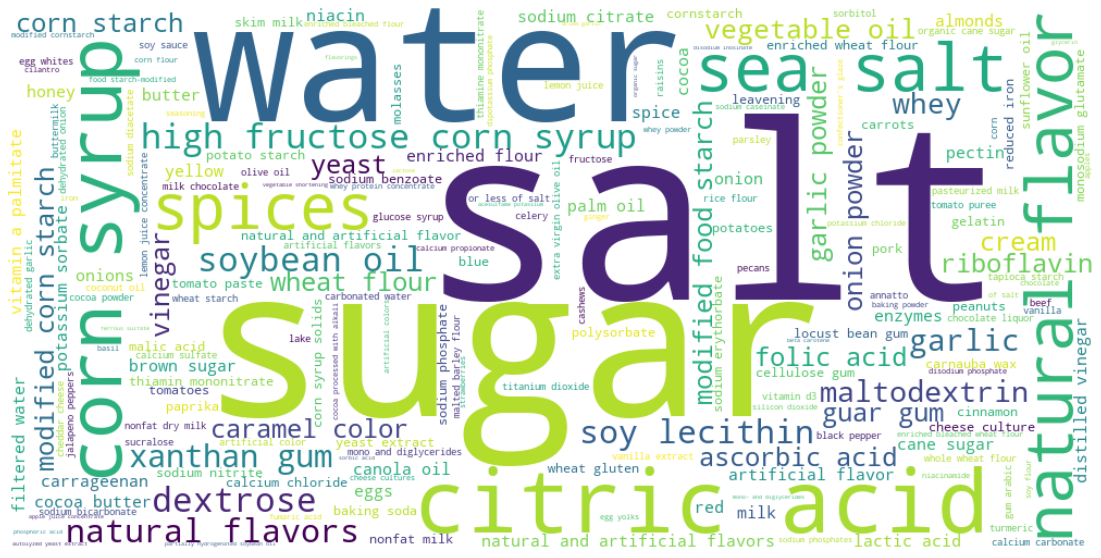

In [224]:
d = {}
counter = 0
for a in counts.ingredient:
    d[a] = counts.apparition[counter]
    counter = counter + 1
    
    
wordcloud = WordCloud(width = 1000, height = 500, background_color="white")
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

_**Comments:**<br>
With this first analysis we can already see some obvious patterns emerging: without any surprise the three most common ingredients are salt, sugar and water._

_Now we would like to plot our products on a 2D map grouped by clusters given their ingredients. This can be done using a dimensionality reduction algorithm. One of them is called t-SNE and can achieve this task fairly efficiently. The idea is to create a matrix of products which has 1k columns, one for each ingredient in the ranking by number of occurrence, and each cell containing a binary value describing if the ingredient is present or absent for this product. Ingredients beyond this ranking are irrelevant because they appear only so rarely, moreover it would make the algorithm unnecessarily slower._

In [225]:
# Number of ingredients (= dimensions) to consider
n_dimensions = 1000
# Number of rows (= datapoints) to consider at most
n_rows = 100000

# Minimum number of ingredients appearing in the list
min_ingredients = 3

relevant = by_count.head(n_dimensions).index.tolist()
products = exploded.iloc[df_nutrition.head(n_rows).index]

values = {}
for col in relevant:
    values[col] = products.apply(lambda s: 1 if s == col else 0).groupby(products.index).max()
matrix = pd.DataFrame(values)

matrix = matrix[matrix.sum(axis=1) >= min_ingredients]

In [226]:
matrix.head(5)

,salt,sugar,water,citric acid,corn syrup,sea salt,natural flavor,spices,high fructose corn syrup,dextrose,...,extractive of paprika,asparagus,cultured pasteurized nonfat milk,a b vitamin,organic peanuts,semi-sweet chocolate chips,hot sauce,organic brown sugar,red cabbage,diced pears
115,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
117,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
118,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
126,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
128,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


_**Comments:**<br>
The matrix has the shape we want. Note that in the mean time we dropped rows with less than 3 ingredients in the matrix because they would create irrelevant datapoint._

_We are now ready to apply the algorithm on the matrix. The execution takes some time._

In [227]:
X = matrix.head(10000)

n_components = 2 # Number of dimensions to reduce to
perplexity = 100 # t-SNE parameter (the higher the better the result, but also the more expensive)
tsne = manifold.TSNE(n_components=n_components, init='random', random_state=0, perplexity=perplexity)
Y = tsne.fit_transform(X)


_**Comments:**<br>
Here we plot some labels to roughly familiarize ourselves with the shape of our map. Here are some possible clusters that the algorithm might have identified:_
- _Chocolate sweets_ <br>
- _Fruit biscuits_<br>
- _Fishes_<br>
- _Cheese_<br>
_We'll see later a robust method to confirm this intuition._

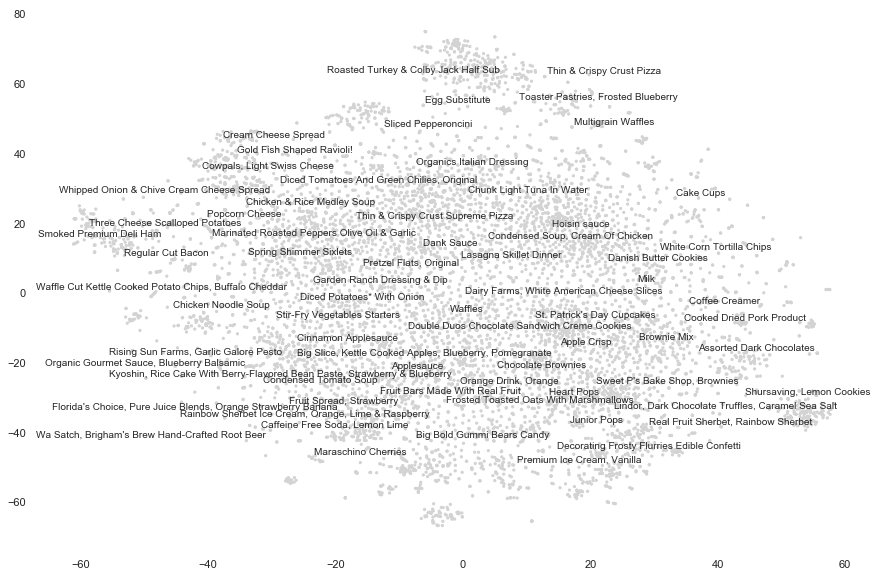

In [228]:
highlight(lambda s: False, 70, size=(15,10))

_**Comments:**<br>
In fact we want to make sure that the clustering is actually meaningful, one way to do that is to prove that the reduced dimensionality is correlated with an independent variable (= unused in the algorithm). One such variable would be the product name. Here we plot in red the products having chocolat in their name. Clearly the product names are correlated with the reduced dimensions. It also confirms the existence of one of the cluster we hypothesized earlier ("chocolate sweets")._

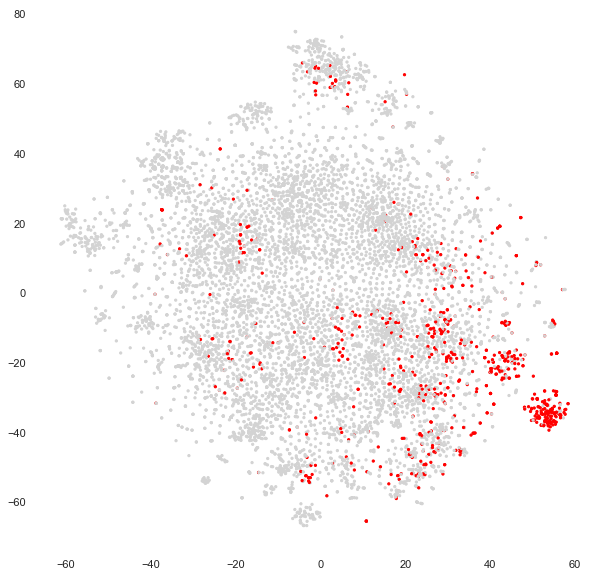

In [229]:
highlight(lambda s: 'chocolate' in s.lower(), 0)

_**Comments:** <br>
Here are some other examples with more keywords:_

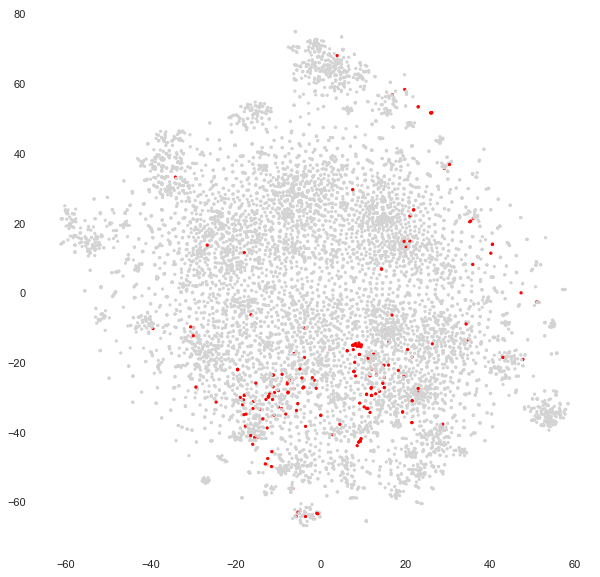

In [230]:
highlight(lambda s: 'fruit' in s.lower(), 0)

_**Comments:**<br>
Let's highlight the ingredients individually to reason about our previous discoveries. Remark that we cannot make any conclusion about the position of the clusters in these plots because it is merely the result of a data representation algorithm. Simply put we only reordered the points so that products with similar ingredients fall close to each other._

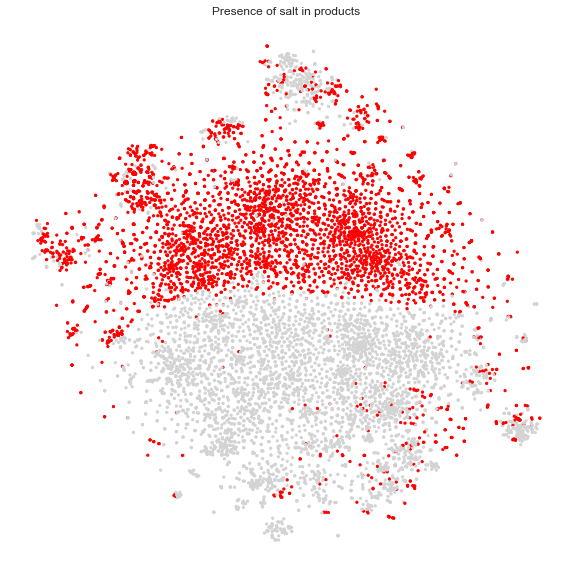

In [231]:
highlight2(['salt'], 'Presence of salt in products')

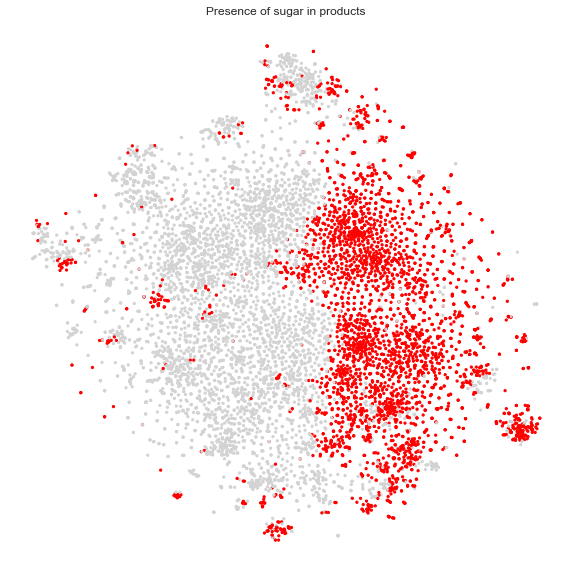

In [232]:
highlight2(['sugar'], 'Presence of sugar in products')

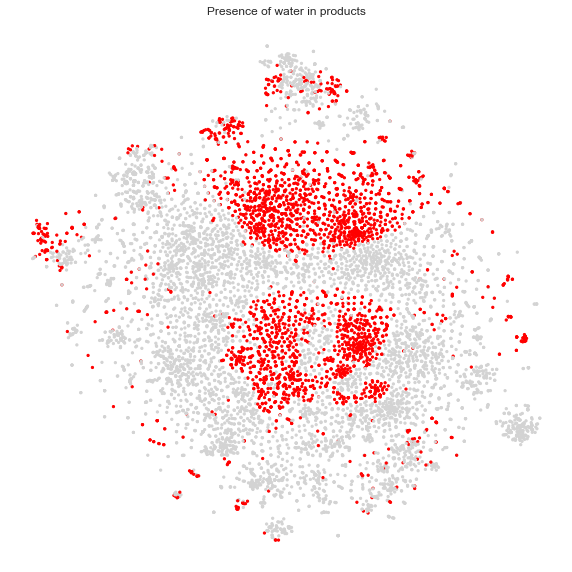

In [233]:
highlight2(['water'], 'Presence of water in products')

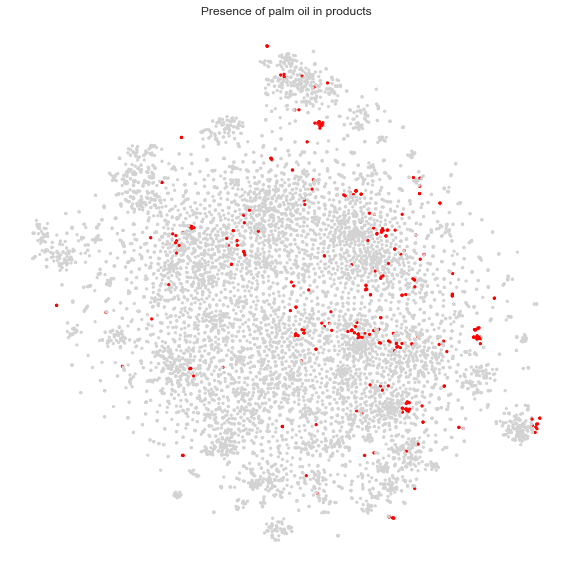

In [234]:
highlight2(['palm oil'], 'Presence of palm oil in products')

In [235]:
# Size of the correlation matrix
n_correlations = 20

cmatrix = np.zeros((n_correlations, n_correlations))
columns = matrix.columns.tolist()[:n_correlations]

# https://en.wikipedia.org/wiki/Phi_coefficient
def phi_corr(n):
    top = n[1][1] * n[0][0] - n[1][0] * n[0][1]
    bot = math.sqrt((n[1][0] + n[1][1]) * (n[0][0] + n[0][1]) \
                    * (n[0][0] + n[1][0]) * (n[0][1] + n[1][1]))
    return top / bot
    
for i in range(n_correlations):
    a = columns[i]
    for j in range(i):
        b = columns[j]
        m = matrix[[a, b]]
        vs = [0, 1]
        result = np.zeros((len(vs), len(vs)))
        for x in vs:
            for y in vs:
                result[x][y] = len(m[(m[a] == x) & (m[b] == y)])

        cmatrix[i][j] = phi_corr(result)

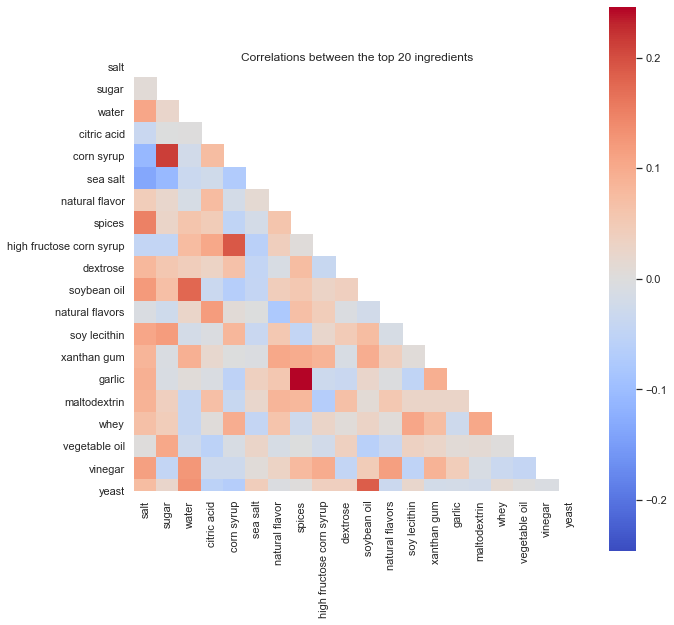

In [236]:
mask = np.zeros_like(cmatrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

m = np.max(np.abs(cmatrix))

fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Correlations between the top %s ingredients' % n_correlations)
sns.heatmap(cmatrix, ax=ax, square=True, mask=mask, vmin=-m, vmax=m, xticklabels=columns, yticklabels=columns, cmap='coolwarm');

## **C. Additives Analysis:**

_**Comments:**<br>
In this part, we are going to discuss the effect of the dangerous food additives on its nutrition grade, and consequently our everyday food consumption.<br>
In fact, the nutrition grade is given in the range from "a" to "e" (from best grade to worst grade). But we want to know if the food products with the dangerous additives, or the most additives have good or bad nutrition grades._

_Hence, in order to determine which additives are bad we are going to first use the list in the **"Hungry for Change"** website. This list contains the most dangerous food additives that we can find on the market, but are not forbidden.
This list was collected using different scientific studies on the matter._


_Source:_
http://www.hungryforchange.tv/article/top-10-food-additives-to-avoid)

In [239]:
df_new = openfoodfacts.additives_tags.dropna().map(lambda x : x.lower())
df_e250 = df_new.str.contains('e250')
df_nutrition = openfoodfacts.nutrition_grade_fr
df_both = openfoodfacts.iloc[df_e250.index]

In [240]:
df_both = df_both[['additives_tags', 'nutrition_grade_fr']]

In [241]:
df_both[df_both.nutrition_grade_fr.notnull()].sample(5)

,additives_tags,nutrition_grade_fr
441683,"en:e202,en:e330",e
949047,en:e1510,c
446305,"en:e150d,en:e330",e
407041,en:e160b,e
659343,"en:e330,en:e440",d


In [242]:
order = ['a', 'b', 'c','d','e']

df_result_e250 = pd.DataFrame(df_both.nutrition_grade_fr)

def grade_dist(title, df_dist):
    fig = df_dist.apply(pd.value_counts).loc[order].plot(kind='bar', subplots=True)
    plt.rcParams['axes.facecolor'] = 'white'
    plt.title(title)
    plt.xlabel("Nutrition Grade")
    plt.ylabel("Number of products")
    plt.show();

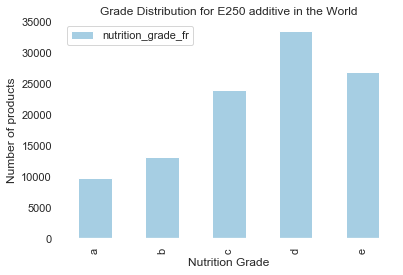

In [243]:
grade_dist("Grade Distribution for E250 additive in the World", df_result_e250)

**Comment**:

_Here we do find the e250 additive (Used for curing(preserving) meat and fish products) which can cause acute methemoglobinemia (haemoglobin loses its ability to carry oxygen), irritability, lack of energy, headache, brain damages or even death in severe untreated cases.
However, what is alarming is that we find many products which have this additive, but keep a "a" and "b" nutrition grade._

_Now, we are going to do the same analysis on a the list given by the "Hungry for Change" website on the world dataset, and on the specific US dataset._

In [255]:
list_dangerous_additives = ['e951','e621', 'e133', 'e124','e110', 'e102', 'e221', 'e320', 'e220']
kwstr = '|'.join(list_dangerous_additives)
mask = df_new.to_frame().stack().str.contains(kwstr).any(level=0)
df_additives = df_new[mask]
df_all = openfoodfacts.iloc[df_additives.index]
df_all = df_all[['additives_tags', 'nutrition_grade_fr']]

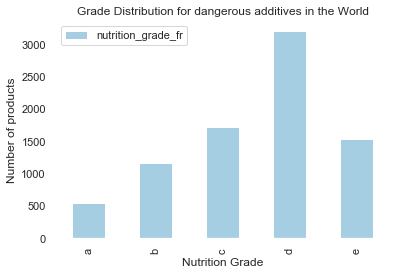

In [256]:
df_result_all = pd.DataFrame(df_all.nutrition_grade_fr)
grade_dist("Grade Distribution for dangerous additives in the World", df_result_all)

**Comment**:
_As you can see from the two plots above, is that most of the products (in both the world and the US do have a nutrition grade of "d", which is a pretty bad grade, but is not the worst grade.
Hence, now we can start discussion the impact of many dangerous additives on our food consumption._

In [257]:
df = openfoodfacts
df.countries = df.countries.str.lower()

# Fix some of the names with multiple entries
df.loc[df['countries'] == 'en:fr','countries'] = 'france'
df.loc[df['countries'] == 'en:es','countries'] = 'spain'
df.loc[df['countries'] == 'en:gb','countries'] ='united kingdom'
df.loc[df['countries'] == 'en:uk','countries'] ='united kingdom'
df.loc[df['countries'] == 'españa','countries'] ='spain'
df.loc[df['countries'] == 'us','countries'] = 'united states'
df.loc[df['countries'] == 'en:us','countries'] ='united states'
df.loc[df['countries'] == 'usa','countries'] = 'united states'
df.loc[df['countries'] == 'en:cn','countries'] = 'canada'
df.loc[df['countries'] == 'en:au','countries'] = 'australia'
df.loc[df['countries'] == 'en:de','countries'] ='germany'
df.loc[df['countries'] == 'deutschland','countries'] ='germany'
df.loc[df['countries'] == 'en:be','countries'] ='belgium'
df.loc[df['countries'] == 'en:ma','countries'] ='morocco'
df.loc[df['countries'] == 'en:ch','countries'] ='switzerland'

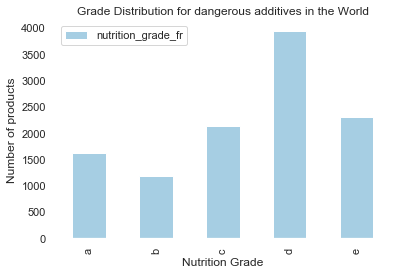

In [259]:
us = ['united states']
df_us = df[df.countries.isin(us)]

df_new_us = df_us.additives_tags.dropna().map(lambda x : x.lower())
df_additives_us = df.iloc[df_new_us.index]

df_result_additives_us = pd.DataFrame(df_additives_us.nutrition_grade_fr)
grade_dist("Grade Distribution for dangerous additives in the US", df_result_additives_us)

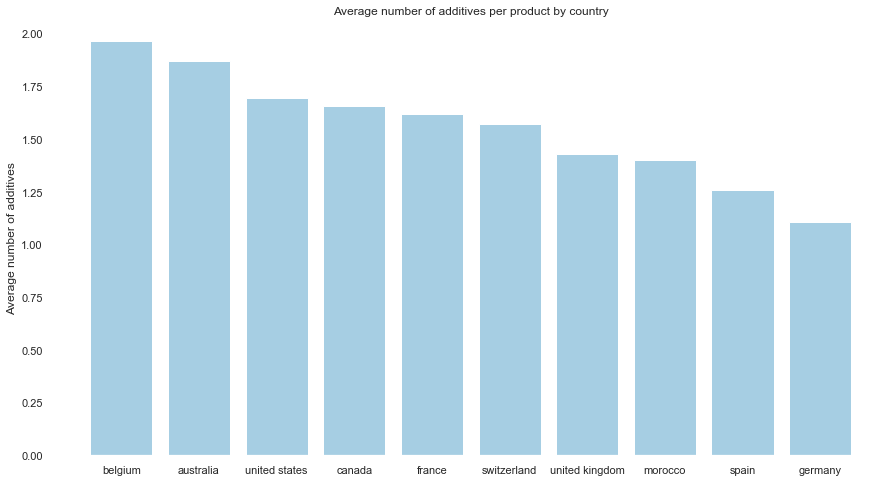

In [260]:
countries = ['france','united kingdom','spain','germany','united states','australia','canada', 'belgium', 'morocco', 'switzerland']
df_countries = df[df.countries.isin(countries)]
df_countries = df_countries[df_countries.additives_n.notnull()]
df_groupedby_countries = df_countries.groupby(['countries']).mean().additives_n.reset_index()

np_countries = np.array(df_groupedby_countries)
np_countries = np_countries[np_countries[:,1].argsort()[::-1]]

# Plot the average number of additives per country
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(1,1,1)
y_pos = np.arange(len(np_countries[:,0]))
x_pos = np_countries[:,1]
x_ticks = np_countries[:,0]

# Make a barplot
plt.bar(y_pos, x_pos, align='center')
plt.title('Average number of additives per product by country')
plt.xticks(y_pos, x_ticks)
plt.ylabel('Average number of additives') 
plt.show()

**Comments:**<br>

Here, we are ranking 10 countries from our list of countries in the dataset, in order to identify the countries which use the biggest average number of additivs per product.
Normally, this ranking should reflect the food consumption habits and use of additives of its population. <br>
It can be clearly seen that Belgium and Australia use the most additives out of these countries, and spain and germany the least. This also demonstrates the most healthy and unhealthy additives habits of these countries.

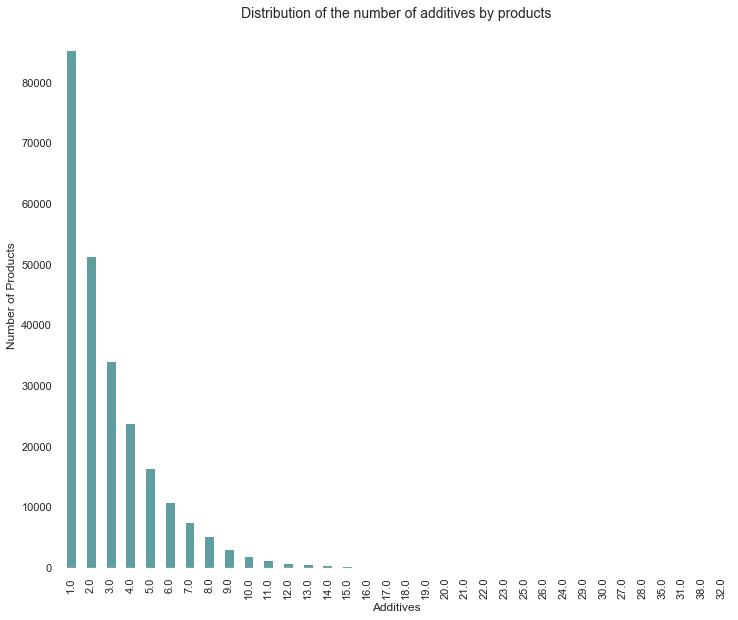

In [261]:
def prod_dist(title, feature, xlabel):
    plt.figure(figsize=(12,10))
    ax = df[df[feature] > 0.0][feature].value_counts().plot(kind='bar',color='cadetblue')
    plt.title(title,fontsize=14)
    plt.xlabel(xlabel)
    plt.ylabel('Number of Products')
    plt.show();

prod_dist('Distribution of the number of additives by products','additives_n', 'Additives')

**Comment**: <br>
_This plot shows the distribution of the number of additives by products. It can be clearly seen that most of the products use 1 to 5 additives in their composition. However, what is astonishing is that we do find products with more than 15 additives in total ! Based on our research, the types of additives used are regulated and has to be approved prior to use. However, there is no limitations for the number of additives that can be added to food products._

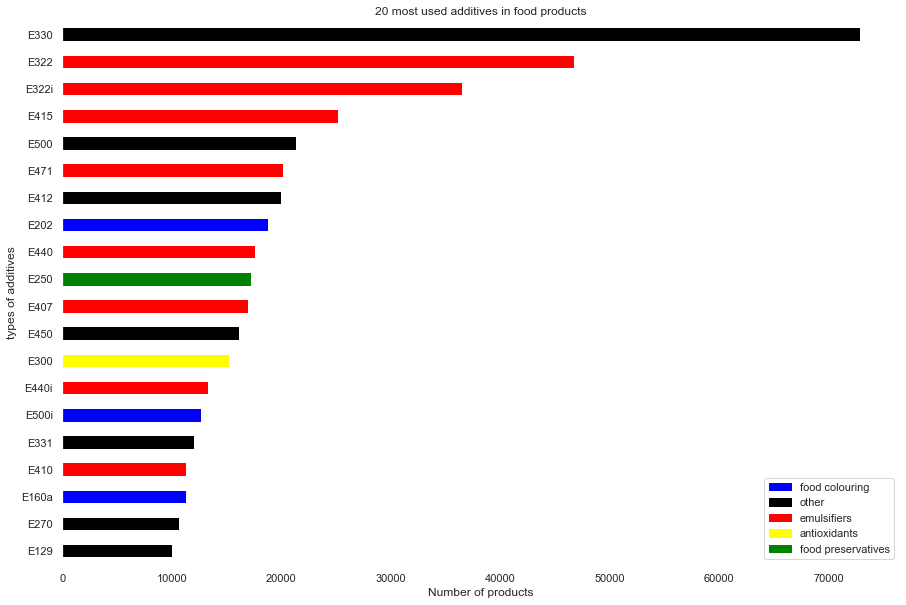

In [262]:
import matplotlib.patches as mpatches

additives = (df['additives_en'].str.extractall("(?P<Count>[E]\d\d\d\w?)"))
additives_count = additives.apply(pd.value_counts).head(20)
additives_count['additives_num'] = additives_count.index
additives_count.reset_index(drop=True,inplace=True)


additives_mapping = {'E330': 'black','E322':'red','E322i':'red','E101':'blue','E375':'black','E101i':'blue',
                    'E300':'yellow','E415':'red','E412':'black','E500':'black','E471':'red','E203':'green','E407':'red',
                    'E440':'red','E250':'green','E150a':'blue','E450':'black','E500i':'blue','E331':'black',
                     'E129':'black','E339':'black','E440i':'red','E160a':'blue','E270':'black','E102':'blue',
                     'E410':'red','E133':'blue','E341':'black','E428':'red','E621':'black','E202':'blue'}

additives_count['colors'] = additives_count['additives_num'].map(additives_mapping)

ax = additives_count.plot(x='additives_num',y='Count',kind='barh',color=additives_count['colors'],figsize=(15,10))
ax.invert_yaxis()
ax.legend().set_visible(False)
ax.set_title('20 most used additives in food products')

colors = mpatches.Patch(color='blue', label='food colouring')
others = mpatches.Patch(color='black', label='other')
emulsifiers = mpatches.Patch(color='red', label='emulsifiers')
antioxidant = mpatches.Patch(color='yellow', label='antioxidants')
preservatives = mpatches.Patch(color='green', label='food preservatives')

plt.legend(handles=[colors,others,emulsifiers,antioxidant,preservatives])
plt.xlabel('Number of products')
plt.ylabel('types of additives')
plt.show();

**Comment**: <br>
This is the ranking of the 20 most used additives by number of products, and we distinguish the classes of additives. <br>
In fact, this complete list of dangerous additives and their classes was taken from the World Health Organization and the FDA. And as you can see above, the most dangerous and popular additives in food products are "emulsifiers" (and "other") additives present in more than 100000 products in the dataset.

_Sources:_<br>
https://www.fda.gov/food/food-additives-petitions/food-additive-status-list<br>
https://www.who.int/en/news-room/fact-sheets/detail/food-additives


## **D. Allergens Analysis:**

_**Comments:**
In this part, we are going to study the impact of allergens on the nutrition grade.<br>
More specifically, this part will also take into consideration the US-special case in order to compare it to the rest of the world._

In [263]:
df_us_allergens = df_us[['nutrition_grade_fr', 'allergens']]
df_allergens_notnull = df.allergens.dropna() 

print('the Shape of the US Dataframe : ', df_us.shape)
print('Number of Allergens Descriptions in the whole Dataframe : ', len(df_allergens_notnull.index))
print('Number of Allergens Descriptions in the US Dataframe : ', len(df_us_allergens.allergens.dropna().index))

the Shape of the US Dataframe :  (176035, 175)
Number of Allergens Descriptions in the whole Dataframe :  82895
Number of Allergens Descriptions in the US Dataframe :  845


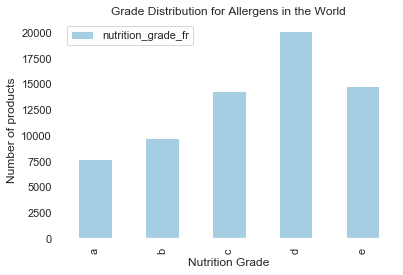

In [264]:
df_new = df.allergens.dropna().map(lambda x : x.lower())
df_allergens = df.iloc[df_new.index]
df_result_allergens = pd.DataFrame(df_allergens.nutrition_grade_fr)
grade_dist("Grade Distribution for Allergens in the World", df_result_allergens)

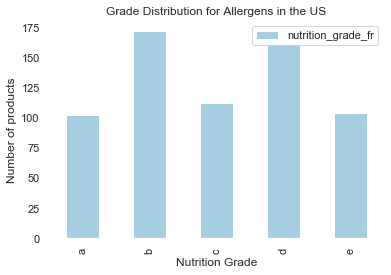

In [265]:
df_new_us = df_us.allergens.dropna().map(lambda x : x.lower())
df_us_allergens = df.iloc[df_new_us.index]
df_result_us_allergens = pd.DataFrame(df_us_allergens.nutrition_grade_fr)
grade_dist("Grade Distribution for Allergens in the US",df_result_us_allergens)


_**Comment (to be updated)**:<br>
In this part, we see that for the rest of the world, we have a high distribution of allergens in the worst grades (similar to additives)._<br>

_However, the distribution of the allergens on the US market, show a total imbalance on the nutrition grade. In fact, we have the same number of products with grade "b" and grade "d". This imbalance can also be explained by the low number of products with "allergens" labels on them. (845 for the US, and 82895 for the rest of the world)
Hence, we can conclude that the impact of the allergens on the US products cannot be proven._

## **E. Palm Oil Analysis:**

_**Comments**:<br>
Finally, we are going to study the use of palm oil ingredients (or ingredients that may be from palm oil) on the food consumption._

In [266]:
palm_list = ['ingredients_from_palm_oil_n',
 'ingredients_from_palm_oil',
 'ingredients_from_palm_oil_tags',
 'ingredients_that_may_be_from_palm_oil_n',
 'ingredients_that_may_be_from_palm_oil',
 'ingredients_that_may_be_from_palm_oil_tags','nutrition_grade_fr']

df_palm = df[palm_list]
df_us_palm = df_us[palm_list]

print('the number of the Palm Oil products in the whole dataframe : ', len(df_palm.ingredients_from_palm_oil_n.dropna().index))
print('the number of the Palm Oil products in the US dataframe : ', len(df_us_palm.ingredients_from_palm_oil_n.dropna().index))

the number of the Palm Oil products in the whole dataframe :  447135
the number of the Palm Oil products in the US dataframe :  170906


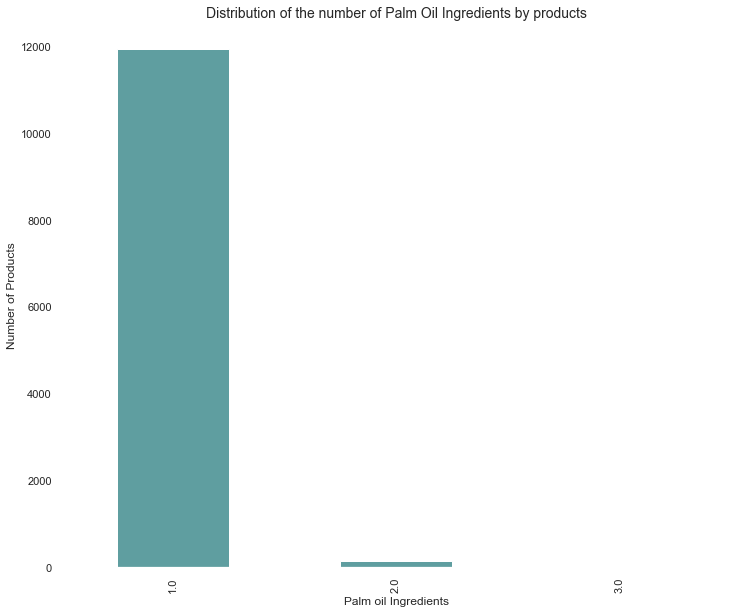

In [267]:
prod_dist('Distribution of the number of Palm Oil Ingredients by products','ingredients_from_palm_oil_n', 'Palm oil Ingredients' )

_**Comments**:<br>
Here we wanted to see the distribution of the number of palm oil ingredients in some of our products (in the world dataset). Hence, most of the products only contain one product containing palm oil. But we do have food products with 3 ingredients containing palm oil, which is inevitably bad for your health._

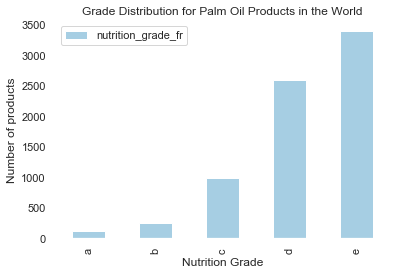

In [268]:
df_new = df.ingredients_from_palm_oil_tags.dropna().map(lambda x : x.lower())
df_palm_ingredients = df.iloc[df_new.index]
df_result_palm = pd.DataFrame(df_palm_ingredients.nutrition_grade_fr)
grade_dist("Grade Distribution for Palm Oil Products in the World",df_result_palm )

C:\Users\smail\Anaconda3\envs\ada\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


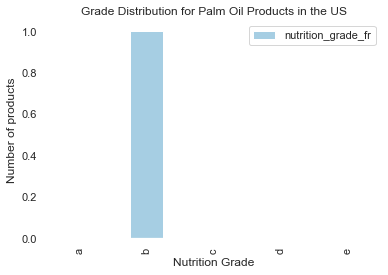

The number of products studied in the US Palm Oil Dataframe is only :  3


In [269]:
df_new_us = df_us.ingredients_from_palm_oil_tags.dropna().map(lambda x : x.lower())
df_palm_us_ingredients = df.iloc[df_new_us.index]
df_result_us_palm = pd.DataFrame(df_palm_us_ingredients.nutrition_grade_fr)
grade_dist("Grade Distribution for Palm Oil Products in the US", df_result_us_palm)

print('The number of products studied in the US Palm Oil Dataframe is only : ', len(df_palm_us_ingredients.index))

_**Comment (to be updated)**:<br>
To conclude, we wanted to see the distribution of food products containing palm oil ingredients in regard to the nutrition grade.<br>
Hence, with no surprise, we see that the number of products increase gradually with the negative grades (the most number of products have the worst grade which is "e") in the world dataset.
However, we cannot conclude anything the US dataset because we only have 3 products containing in their labels the "palm oil" tag. This can be explained by the fact that many US lobbies want their products to continue using palm oil without informing the public. (source "The Guardian")_

Source:
https://www.theguardian.com/news/2019/feb/19/palm-oil-ingredient-biscuits-shampoo-environmental

### **F. Correlation Between Nutrition Grade (FR) and allergens, additives and palm oil ingredients:**

In [270]:
sns.set(style="white")

# Generate a large random dataset

list_additives_palm = ['nutrition_grade_fr', 'additives_n', 'ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n' ]

def corr_matrix(df_test, title):
    fig = plt.figure(figsize=(20,20))
    df_test_new = df_test[list_additives_palm]
    df_test_new = pd.get_dummies(df_test_new, columns=['nutrition_grade_fr'])
    plt.matshow(df_test_new.corr())
    plt.title(title)
    plt.show();

<Figure size 1440x1440 with 0 Axes>

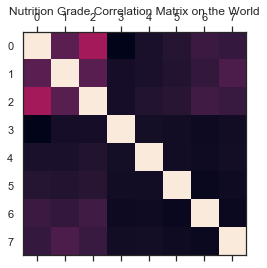

In [271]:
corr_matrix(df, 'Nutrition Grade Correlation Matrix on the World');

<Figure size 1440x1440 with 0 Axes>

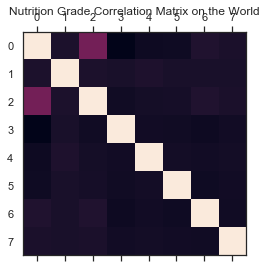

In [272]:
corr_matrix(df_us, 'Nutrition Grade Correlation Matrix on the World')

_**Comments:**
Here we wanted to plot the correlation matrices regarding our findings in the 3 previous parts : we only find a correlation between additives and palm oil (0 and 2 columns)._

# **PART 3 : &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Joining Dunnhumby and OpenFoodFacts**

We proceeded to cleaning each one of the two datasets, then analyzed most of their features as well as their correlations. Now the two datasets are ready to be joined. these products. The idea is to complete the Dunnhumby dataset by adding to products purchased by households information about their ingredients and nutritive value, in order to evaluate the healthiness of the food product. Dunnhumby classifies food products at different levels, Subcommodity, commoditiy and  Department. While OpenFoodFacts has a Product name attribute and a Category feature. Comparing these features we decided to merge the two datasets based on the subcommodity attribute for Dunnhumby and the product name for OpenFoodFacts. Indeed, these have the closest product classification level.<br>
However the labels are not exactly the same between Subcommodity and  Product name. We need to implement a function that finds the product in OpenFoodFacts with the closest name to a subcommodity in Dunnhumby. For this we use the Difflib function SequenceMatcher, which compares two strings and provides a ratio indicating the ‘closeness’ of the two names. Using a threshold method we keep the pairs found with a ratio above 0.7 (this value can be changed in the future). We also add two rules in order to give priority to exact matches, and to the product names included in the subcommodity name or vis-versa.<br>
We ran the function, which took a lot time to execute, and constructed a dictionary on products name matches between Dunnhumby (keys) and OpenFoodFacts(values). We can notice that we have a lot of exact matches, and a big number of good results. But there are also a lot of errors caused by the fact that two strings can be very close but the products are different, for example ‘coffee filter’ and ‘coffee waffle’.<br> 
For now, we decided to keep the shown dictionary for this report, but we are exploring other string comparison methods and improving our function in order to get better results, and reduce the number of False positives for the dataset to be cleaned manually if there are remaining errors.

In [ ]:
flag = False
dic = {}
for i in df.SUB_COMMODITY_DESC.unique():
    print(i)
    d1 = {}
    d2 = {}
    flag = False
    flag_in = False
    for j in off.product_name.unique():
        if i == j:
            print('dunhumby : ', i,', openfoodfacts : ', j,', equal')
            dic[i] = j
            flag = False
            flag_in = False
            break
        elif (i in j) or (j in i):
            s = SequenceMatcher(None, i, j)
            d2[j] = s.ratio()
            flag_in = True
        else:
            s = SequenceMatcher(None, i, j)
            d1[j] = s.ratio()
            flag = True
    if flag_in:
        m2 = max(d2.values())
        key_list2 = list(d2.keys()) 
        val_list2 = list(d2.values())
        if flag:
            m1 = max(d1.values())
            key_list1 = list(d1.keys()) 
            val_list1 = list(d1.values())
            if m2>=m1:
                print('dunhumby : ', i,', openfoodfacts : ', key_list2[val_list2.index(m2)],', ratio :', m2, ', in')
                dic[i] = key_list2[val_list2.index(m2)]
            else:
                if m1 >= 0.7:
                    print('dunhumby : ', i,', openfoodfacts : ', key_list1[val_list1.index(m1)],', ratio :', m1)
                dic[i] = key_list1[val_list1.index(m1)]
        else:
            print('dunhumby : ', i,', openfoodfacts : ', key_list2[val_list2.index(m2)],', ratio :', m2, ', in')
            dic[i] = key_list2[val_list2.index(m2)]
    elif flag:
        m = max(d1.values())
        key_list = list(d1.keys()) 
        val_list = list(d1.values())
        if m>=0.8:
            print('dunhumby : ', i,', openfoodfacts : ', key_list[val_list.index(m)],', ratio :', m)
            dic[i] = key_list[val_list.index(m)]

In [280]:
matches = pd.read_csv('output.csv', header=None, names=['Dunnhumby', 'OpenFoodFacts'])

In [281]:
matches.head(50)

,Dunnhumby,OpenFoodFacts
0,liquid laundry detergent,ecos hypoallergenic laundry detergent
1,banana,banana
2,tray pack choc chip cooky,extra chocolate chip cooky
3,mandarin orange citrus sect,mandarin orange simmer sauce
4,candy bag chococlate,candy chocolate
5,macaroni cheese dnrs,macaroni cheese dinner
6,sandwich bun,sandwich bun
7,snack cracker,snack cracker
8,soft drink pk can car,soft drink kirin
9,macaroni dry,macaroni
